<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [15]</a>'.</span>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gc import callbacks
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import json
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import plot_model
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from time import strftime
import random
import MyLibrary as ml
import pandas as pd
import scipy.io as sio
import sys
print(sys.executable)
print("Tensorflow version: ",tf.__version__)

2024-06-06 11:09:17.783750: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 11:09:17.786882: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.


2024-06-06 11:09:18.698559: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/ailabguest/anaconda3/envs/py39all/bin/python
Tensorflow version:  2.16.1


In [2]:
from tensorflow.keras.utils import Sequence
import numpy as np

class DynamicDataGenerator(Sequence):
    def __init__(self, data_paths, dataGroup: dict, window_size, batch_size=32, step_size=1):
        try:
            print("Inizializzazione DynamicDataGenerator...")
            self.data_paths = ml.read_json_file(data_paths)  # Lista dei percorsi ai file dei dati
            self.dataGroupbloccked = dataGroup.copy()
            print("dataGroup:", self.dataGroupbloccked)
            self.dataGroup = self.dataGroupbloccked.copy()
            self.keyattuale, self.canaliAttuali = self.dataGroup.popitem()
            self.canaleAttuale = self.canaliAttuali.pop(0)
            self.ultimafinestra = 0
            #self.indices = self._generate_indices_dinamic()
            self.window_size = window_size
            self.batch_size = batch_size
            self.step_size = step_size
        except Exception as e:
            print("Errore durante l'inizializzazione:", e)
            
    def _generate_indices_dinamic(self):
        indices = []
        json = ml.read_json_file(self.data_paths[self.keyattuale])
        data_length = self._get_data_length(json, self.canaleAttuale)
        if self.canaliAttuali:
            if self.ultimafinestra > data_length:
                self.aggiornaCanale()
            else:
                self.aggiornaKeyCanali()
            
        for _ in range(self.batch_size):
            indices.append((self._get_path(json, self.canaleAttuale), self.ultimafinestra))
            self.ultimafinestra += self.step_size
        return indices
    
    def _get_path(self, json, channel):
        try:
            # Ottieni il percorso del file per la chiave specificata
            return json[channel]["paths"]["assoluto"]
        except KeyError as e:
            print(f"Chiave non trovata nel JSON per il canale {channel}: {e}")
            return None
    
    def _get_data_length(self, json, channel):
        try:
            # Implementa la funzione per ottenere la lunghezza dei dati dal file
            return json[channel]["shape"][0]
        except KeyError as e:
            print(f"Chiave non trovata nel JSON per il canale {channel}: {e}")
            return 0
    
    def _load_data(self, path, start, end):
        try:
            # Implementa la funzione per caricare solo una porzione dei dati
            data = ml.MatToDataFrame(path, key='singleData', IsColpitePath=True)
            datasegment = data[start:end]
            del data
            return datasegment
        except Exception as e:
            print(f"Errore durante il caricamento dei dati da {path} tra {start} e {end}: {e}")
            return None
    
    def __len__(self):
        """
        Calcola il numero di batch per epoca.
        Returns:
            int: Il numero di batch per epoca.
        """
        Dimtot = self.calcolaDimTot()  # Calcola la dimensione totale dei dati
        
        if Dimtot < self.window_size:
            raise ValueError("La dimensione totale dei dati è inferiore alla dimensione della finestra.")
        
        if self.window_size < self.step_size:
            raise ValueError("La dimensione della finestra è più piccola dello step size.")
        
        total_windows = (Dimtot - self.window_size) // (self.step_size + 1)  # Numero totale di finestre possibili
        num_batches = total_windows // self.batch_size  # Numero di batch

        print("Lunghezza:", num_batches)
        return int(num_batches)

    
    def calcolaDimTot(self):
        dim=0
        for key in self.dataGroupbloccked.keys():
            json = ml.read_json_file(self.data_paths[key])
            for canali in list(self.dataGroupbloccked.values()):
                for canale in canali:
                    data_length = self._get_data_length(json, canale)
                    dim=dim+data_length
        return dim
    
    def __getitem__(self, index):
        print("Index:", index)
        # Ottieni gli indici per il batch corrente
        batch_indices = self._generate_indices_dinamic()
        
        # Carica e processa i dati per il batch corrente
        batch = []
        for (path, start) in batch_indices:
            end = start + self.window_size
            data = self._load_data(path, start, end)
            if data is not None:
                # Padding
                if len(data) < self.window_size:
                    padding_needed = self.window_size - len(data)
                    data = np.pad(data, ((0, padding_needed), (0, 0)), 'constant')
                batch.append(data)
        
        # Converti le finestre in array numpy
        batch = np.array(batch)
        
        # Gli autoencoder usano input e output identici
        return batch, batch
    
    def on_epoch_end(self):
        # Reinizializza lo stato del generatore alla fine di ogni epoca
        self.dataGroup = self.dataGroupbloccked.copy()
        
        if not self.dataGroup:
            raise RuntimeError("Il dizionario dei gruppi di dati è vuoto dopo l'inizializzazione.")
        
        self.keyattuale, self.canaliAttuali = self.dataGroup.popitem()
        
        if not self.canaliAttuali:
            raise RuntimeError("La chiave iniziale non ha canali associati.")
        
        self.canaleAttuale = self.canaliAttuali.pop(0)
        self.ultimafinestra = 0

    def aggiornaCanale(self):
        if not self.canaliAttuali:
            raise RuntimeError("Nessun canale rimanente nella lista attuale, aggiornamento della chiave e dei canali.")
        
        self.ultimafinestra = 0
        self.canaleAttuale = self.canaliAttuali.pop(0)

    def aggiornaKeyCanali(self):
        if not self.dataGroup:
            raise RuntimeError("Nessuna chiave rimanente nel dizionario dei gruppi di dati.")
        
        self.ultimafinestra = 0
        self.keyattuale, self.canaliAttuali = self.dataGroup.popitem()
        
        if not self.canaliAttuali:
            raise RuntimeError("La nuova chiave non ha canali associati.")
        
        self.canaleAttuale = self.canaliAttuali.pop(0)


In [3]:
def estrarre_channalli(NummeroDiCanaliPerEsperimento=10):
    nc=NummeroDiCanaliPerEsperimento  
    pathsDastaSet=ml.read_json_file(r"json/NasaDataSetPath.json")
    paths={}
    for path in pathsDastaSet.keys():
        # Estrai tutte le chiavi del dizionario e mescolale
        my_dict=ml.read_json_file(pathsDastaSet[path])
        keys = list(my_dict.keys())
        random.shuffle(keys)

        # Genera un numero casuale minore della lunghezza delle chiavi
        numero_casuale = random.randint(0, len(keys) - 1)

        # Determina l'intervallo per selezionare le chiavi
        if nc % 2 == 0:
            start_index = max(0, numero_casuale - nc//2)
            end_index = min(len(keys), numero_casuale + nc//2)
        else:
            start_index = max(0, numero_casuale - nc//2)
            end_index = min(len(keys), numero_casuale + nc//2 + 1)
        # Verifica se l'intervallo contiene almeno 10 chiavi
        if end_index - start_index < nc:
            # Calcola quanti indici aggiuntivi sono necessari per ottenere 10 chiavi
            indici_aggiuntivi = nc - (end_index - start_index)
            # Se ci sono meno chiavi alla fine, estendi l'intervallo all'inizio
            if len(keys) - end_index < indici_aggiuntivi:
                start_index = max(0, start_index - (indici_aggiuntivi - (len(keys) - end_index)))
            # Altrimenti, estendi l'intervallo alla fine
            else:
                end_index = min(len(keys), end_index + indici_aggiuntivi)

        # Seleziona le chiavi all'interno dell'intervallo
        chiavi_selezionate = keys[start_index:end_index]
        paths[path]=chiavi_selezionate
    return paths


In [4]:
fist=ml.read_json_file(r"json/NasaDataSetPath.json")["B101"]
print(fist)
path=ml.read_json_file(fist)["Channel1"]["paths"]["assoluto"]
print(path)
data = ml.MatToDataFrame(path,key='singleData', IsColpitePath=True)
print(data.shape)
print(len(data))

json/NasaDataSet/B101.json
/media/ailab/RAID0/giovannioliverio/DataSet2/DataSetNasa/B101/B101/Channel1.mat
(12287999, 1)
12287999


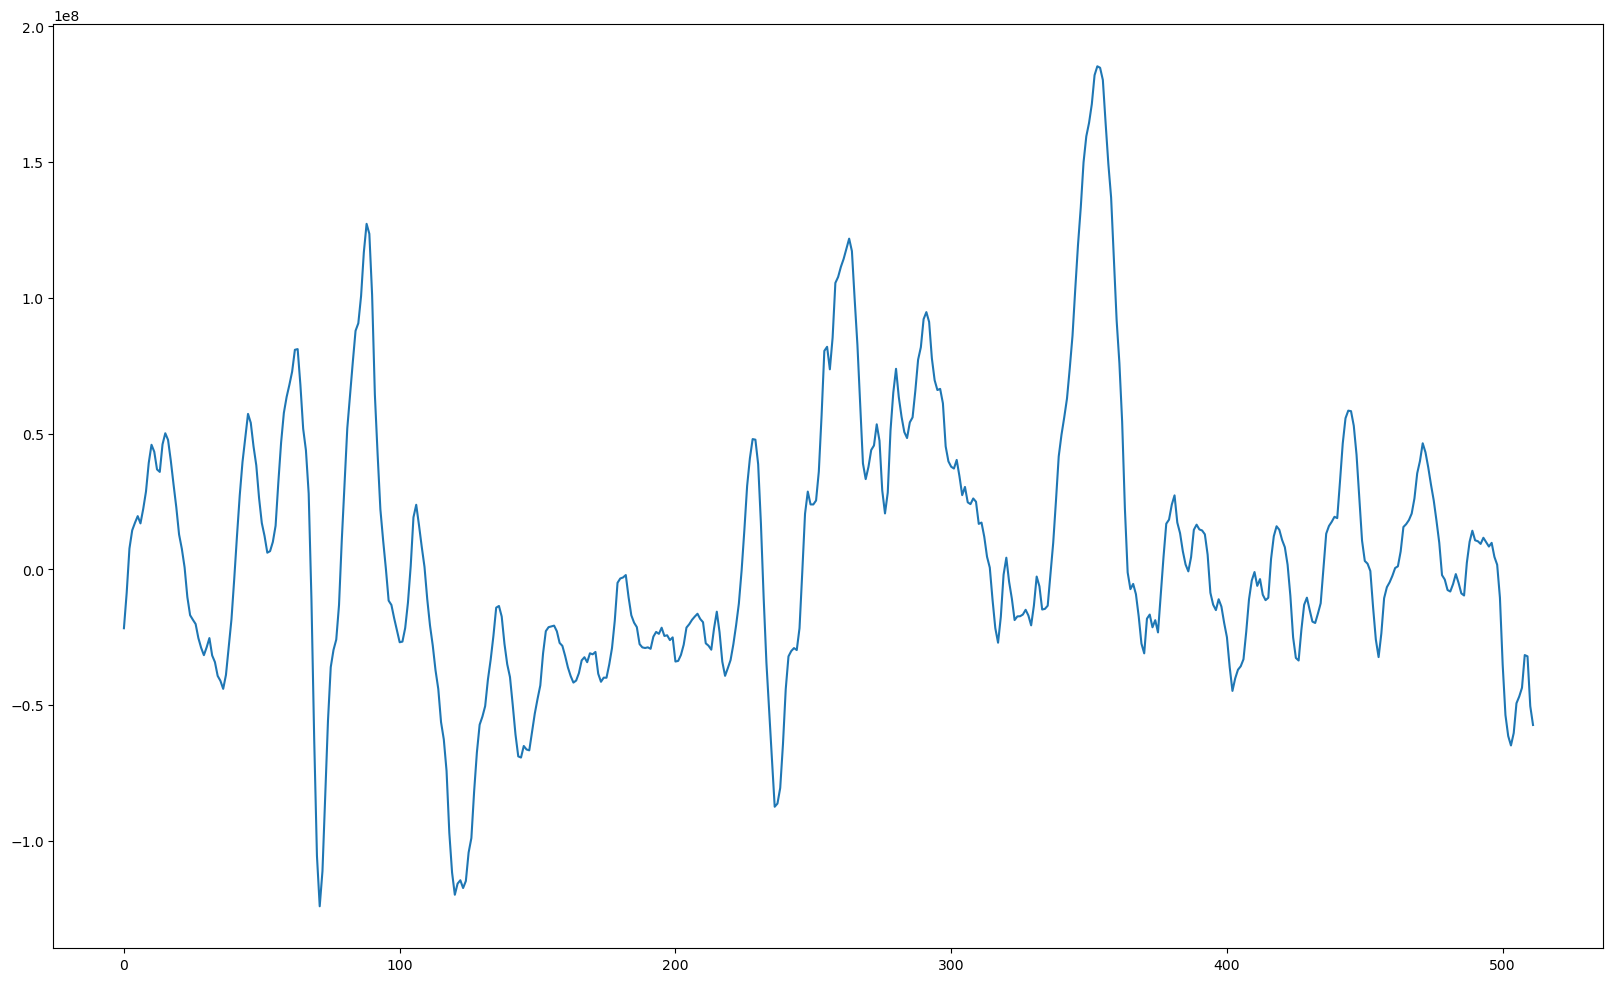

In [5]:

#d.plot()
#data.head()
#print(d)
plt.figure(figsize=(20, 12))
plt.plot(data[:512])

In [6]:
data.rename(columns={0: 'Time-Sequence'}, inplace=True)
data.head(len(data))

,Time-Sequence
0,-21702628.0
1,-8657071.0
2,7671702.0
3,14368814.0
4,17132264.0
...,...
12287994,-31674332.0
12287995,-25849960.0
12287996,-7847381.5
12287997,24490868.0


In [7]:
# Media mobile
data['moving_average'] = data['Time-Sequence'].rolling(window=100).mean()
data.head(len(data))

,Time-Sequence,moving_average
0,-21702628.0,NaN
1,-8657071.0,NaN
2,7671702.0,NaN
3,14368814.0,NaN
4,17132264.0,NaN
...,...,...
12287994,-31674332.0,6269234.575
12287995,-25849960.0,5751858.135
12287996,-7847381.5,5417527.980
12287997,24490868.0,5509994.180


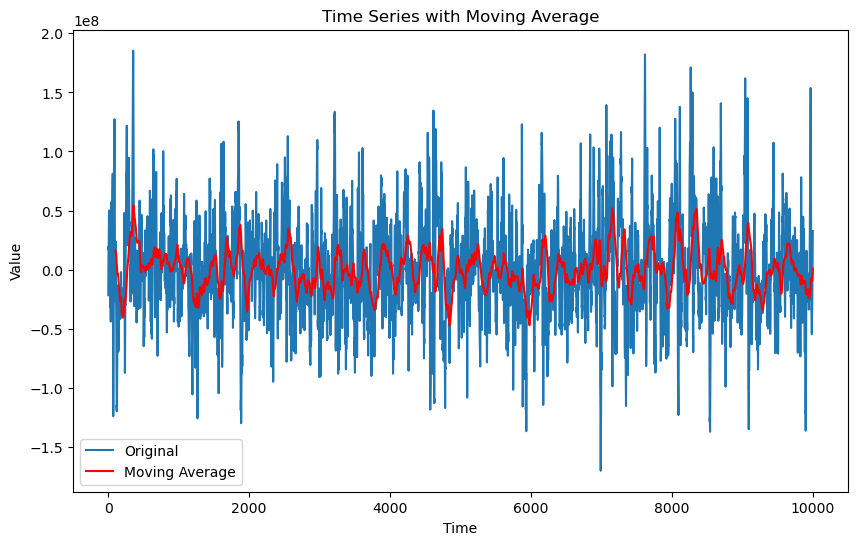

In [8]:

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data['Time-Sequence'][:10000], label='Original')
plt.plot(data['moving_average'][:10000], label='Moving Average', color='red')
plt.title('Time Series with Moving Average')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [9]:
'''import plotly.express as px
import nbformat
print(nbformat.__version__)

# Creazione del grafico interattivo con Plotly
fig = px.line(data, y='Time-Sequence', title='Interactive Time Series Plot')
fig.show()'''

"import plotly.express as px\nimport nbformat\nprint(nbformat.__version__)\n\n# Creazione del grafico interattivo con Plotly\nfig = px.line(data, y='Time-Sequence', title='Interactive Time Series Plot')\nfig.show()"

/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


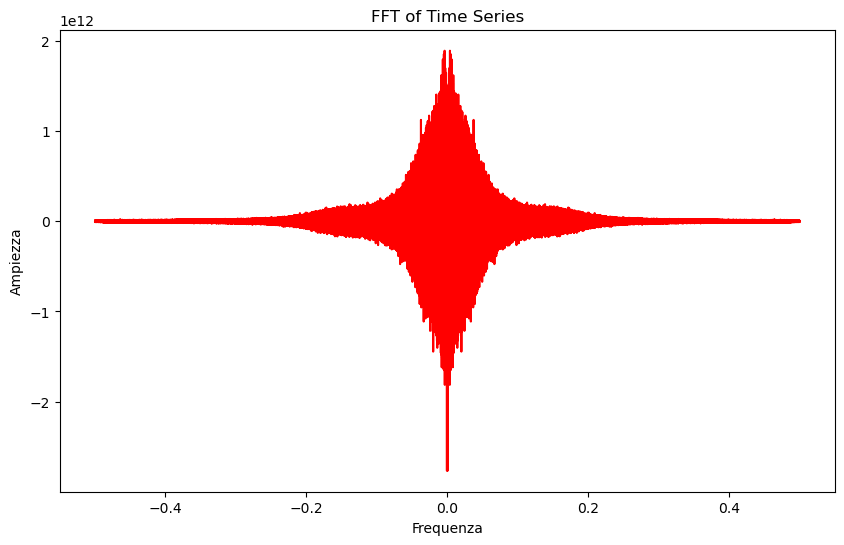

In [10]:
# Trasformata di Fourier
fft = np.fft.fft(data['Time-Sequence'])
fft_freq = np.fft.fftfreq(len(fft))

# Plot dello spettro di frequenza
plt.figure(figsize=(10, 6))
#plt.plot(fft_freq, np.abs(fft))
plt.plot(fft_freq, fft, color='red')
plt.title('FFT of Time Series')
plt.xlabel('Frequenza')
plt.ylabel('Ampiezza')
plt.show()


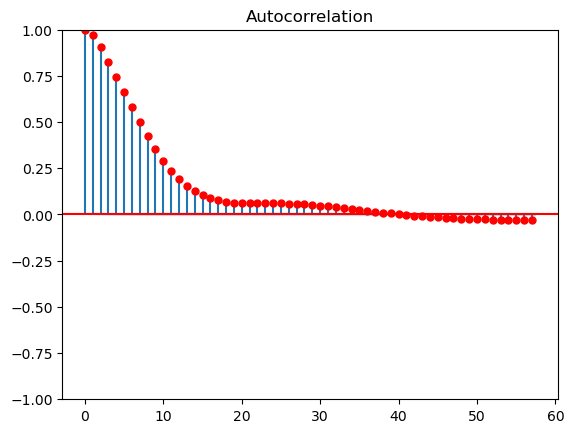

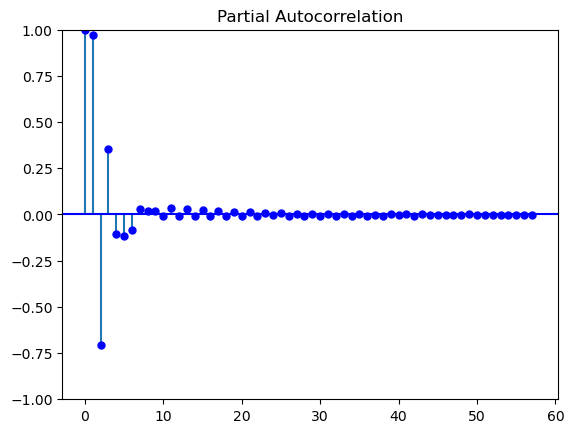

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF e PACF
plot_acf(data['Time-Sequence'][:500000],color='red')
plot_pacf(data['Time-Sequence'][:500000],color='blue')
plt.show()


In [12]:
channalli_estratti=estrarre_channalli(2)
window_size, batch_size, step_size = 512, 32, 512
DynamicDataGenerator=DynamicDataGenerator(r"json/NasaDataSetPath.json",channalli_estratti, window_size, batch_size, step_size)


Inizializzazione DynamicDataGenerator...
dataGroup: {'B101': ['Channel12', 'Channel2'], 'B106': ['Channel7', 'Channel45'], 'B109': ['Channel45', 'Channel31']}


In [13]:
#print(DynamicDataGenerator._generate_indices_dinamic())
print(channalli_estratti)

{'B101': ['Channel12', 'Channel2'], 'B106': ['Channel7', 'Channel45'], 'B109': ['Channel31']}


In [14]:
input_window = Input(shape=(window_size,))
encoder=Sequential([
    Dense(window_size//2, activation='relu'),
    Dense(window_size//4, activation='relu'),
    Dense(window_size//8, activation='relu')
])
encoderWindow = encoder(input_window)
decoder=Sequential([
    Dense(window_size//4, activation='relu'),
    Dense(window_size//2, activation='relu'),
    Dense(window_size, activation='linear'),
])
decoded_window = decoder(encoderWindow)
# Creazione del modello completo dell'autoencoder
autoencoder = Model(inputs=input_window, outputs=decoded_window)
#autoencoder=Sequential([encoderWindow,decoder])

# Stampa della struttura dell'autoencoder
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

2024-06-06 11:09:48.586170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 11:09:48.587056: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64)             │       172,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 512)            │       172,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,408 (1.32 MB)

 Trainable params: 345,408 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [15]:
autoencoder.fit(DynamicDataGenerator, epochs=10, verbose=3,shuffle=False)
autoencoder.summary()
autoencoder.save(r"modello_autoencoder.h5")

Lunghezza: 41169
Lunghezza: 41169
Index: 0


Index: 1


Epoch 1/10


Lunghezza: 41169
Lunghezza: 41169
Index: 0


/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Index: 1


Index: 2


Index: 3


Index: 4


Index: 5


Index: 6


Index: 7


Index: 8


Index: 9


Index: 10


Index: 11


Index: 12


Index: 13


Index: 14


Index: 15


Index: 16


Index: 17


Index: 18


Index: 19


Index: 20


Index: 21


Index: 22


Index: 23


Index: 24


Index: 25


Index: 26


Index: 27


Index: 28


Index: 29


Index: 30


Index: 31


Index: 32


Index: 33


Index: 34


Index: 35


Index: 36


Index: 37


Index: 38


Index: 39


Index: 40


Index: 41


Index: 42


Index: 43


Index: 44


Index: 45


Index: 46


Index: 47


Index: 48


Index: 49


Index: 50


Index: 51


Index: 52


Index: 53


Index: 54


Index: 55


Index: 56


Index: 57


Index: 58


Index: 59


Index: 60


Index: 61


Index: 62


Index: 63


Index: 64


Index: 65


Index: 66


Index: 67


Index: 68


Index: 69


Index: 70


Index: 71


Index: 72


Index: 73


Index: 74


Index: 75


Index: 76


Index: 77


Index: 78


Index: 79


Index: 80


Index: 81


Index: 82


Index: 83


Index: 84


Index: 85


Index: 86


Index: 87


Index: 88


Index: 89


Index: 90


Index: 91


Index: 92


Index: 93


Index: 94


Index: 95


Index: 96


Index: 97


Index: 98


Index: 99


Index: 100


Index: 101


Index: 102


Index: 103


Index: 104


Index: 105


Index: 106


Index: 107


Index: 108


Index: 109


Index: 110


Index: 111


Index: 112


Index: 113


Index: 114


Index: 115


Index: 116


Index: 117


Index: 118


Index: 119


Index: 120


Index: 121


Index: 122


Index: 123


Index: 124


Index: 125


Index: 126


Index: 127


Index: 128


Index: 129


Index: 130


Index: 131


Index: 132


Index: 133


Index: 134


Index: 135


Index: 136


Index: 137


Index: 138


Index: 139


Index: 140


Index: 141


Index: 142


Index: 143


Index: 144


Index: 145


Index: 146


Index: 147


Index: 148


Index: 149


Index: 150


Index: 151


Index: 152


Index: 153


Index: 154


Index: 155


Index: 156


Index: 157


Index: 158


Index: 159


Index: 160


Index: 161


Index: 162


Index: 163


Index: 164


Index: 165


Index: 166


Index: 167


Index: 168


Index: 169


Index: 170


Index: 171


Index: 172


Index: 173


Index: 174


Index: 175


Index: 176


Index: 177


Index: 178


Index: 179


Index: 180


Index: 181


Index: 182


Index: 183


Index: 184


Index: 185


Index: 186


Index: 187


Index: 188


Index: 189


Index: 190


Index: 191


Index: 192


Index: 193


Index: 194


Index: 195


Index: 196


Index: 197


Index: 198


Index: 199


Index: 200


Index: 201


Index: 202


Index: 203


Index: 204


Index: 205


Index: 206


Index: 207


Index: 208


Index: 209


Index: 210


Index: 211


Index: 212


Index: 213


Index: 214


Index: 215


Index: 216


Index: 217


Index: 218


Index: 219


Index: 220


Index: 221


Index: 222


Index: 223


Index: 224


Index: 225


Index: 226


Index: 227


Index: 228


Index: 229


Index: 230


Index: 231


Index: 232


Index: 233


Index: 234


Index: 235


Index: 236


Index: 237


Index: 238


Index: 239


Index: 240


Index: 241


Index: 242


Index: 243


Index: 244


Index: 245


Index: 246


Index: 247


Index: 248


Index: 249


Index: 250


Index: 251


Index: 252


Index: 253


Index: 254


Index: 255


Index: 256


Index: 257


Index: 258


Index: 259


Index: 260


Index: 261


Index: 262


Index: 263


Index: 264


Index: 265


Index: 266


Index: 267


Index: 268


Index: 269


Index: 270


Index: 271


Index: 272


Index: 273


Index: 274


Index: 275


Index: 276


Index: 277


Index: 278


Index: 279


Index: 280


Index: 281


Index: 282


Index: 283


Index: 284


Index: 285


Index: 286


Index: 287


Index: 288


Index: 289


Index: 290


Index: 291


Index: 292


Index: 293


Index: 294


Index: 295


Index: 296


Index: 297


Index: 298


Index: 299


Index: 300


Index: 301


Index: 302


Index: 303


Index: 304


Index: 305


Index: 306


Index: 307


Index: 308


Index: 309


Index: 310


Index: 311


Index: 312


Index: 313


Index: 314


Index: 315


Index: 316


Index: 317


Index: 318


Index: 319


Index: 320


Index: 321


Index: 322


Index: 323


Index: 324


Index: 325


Index: 326


Index: 327


Index: 328


Index: 329


Index: 330


Index: 331


Index: 332


Index: 333


Index: 334


Index: 335


Index: 336


Index: 337


Index: 338


Index: 339


Index: 340


Index: 341


Index: 342


Index: 343


Index: 344


Index: 345


Index: 346


Index: 347


Index: 348


Index: 349


Index: 350


Index: 351


Index: 352


Index: 353


Index: 354


Index: 355


Index: 356


Index: 357


Index: 358


Index: 359


Index: 360


Index: 361


Index: 362


Index: 363


Index: 364


Index: 365


Index: 366


Index: 367


Index: 368


Index: 369


Index: 370


Index: 371


Index: 372


Index: 373


Index: 374


Index: 375


Index: 376


Index: 377


Index: 378


Index: 379


Index: 380


Index: 381


Index: 382


Index: 383


Index: 384


Index: 385


Index: 386


Index: 387


Index: 388


Index: 389


Index: 390


Index: 391


Index: 392


Index: 393


Index: 394


Index: 395


Index: 396


Index: 397


Index: 398


Index: 399


Index: 400


Index: 401


Index: 402


Index: 403


Index: 404


Index: 405


Index: 406


Index: 407


Index: 408


Index: 409


Index: 410


Index: 411


Index: 412


Index: 413


Index: 414


Index: 415


Index: 416


Index: 417


Index: 418


Index: 419


Index: 420


Index: 421


Index: 422


Index: 423


Index: 424


Index: 425


Index: 426


Index: 427


Index: 428


Index: 429


Index: 430


Index: 431


Index: 432


Index: 433


Index: 434


Index: 435


Index: 436


Index: 437


Index: 438


Index: 439


Index: 440


Index: 441


Index: 442


Index: 443


Index: 444


Index: 445


Index: 446


Index: 447


Index: 448


Index: 449


Index: 450


Index: 451


Index: 452


Index: 453


Index: 454


Index: 455


Index: 456


Index: 457


Index: 458


Index: 459


Index: 460


Index: 461


Index: 462


Index: 463


Index: 464


Index: 465


Index: 466


Index: 467


Index: 468


Index: 469


Index: 470


Index: 471


Index: 472


Index: 473


Index: 474


Index: 475


Index: 476


Index: 477


Index: 478


Index: 479


Index: 480


Index: 481


Index: 482


Index: 483


Index: 484


Index: 485


Index: 486


Index: 487


Index: 488


Index: 489


Index: 490


Index: 491


Index: 492


Index: 493


Index: 494


Index: 495


Index: 496


Index: 497


Index: 498


Index: 499


Index: 500


Index: 501


Index: 502


Index: 503


Index: 504


Index: 505


Index: 506


Index: 507


Index: 508


Index: 509


Index: 510


Index: 511


Index: 512


Index: 513


Index: 514


Index: 515


Index: 516


Index: 517


Index: 518


Index: 519


Index: 520


Index: 521


Index: 522


Index: 523


Index: 524


Index: 525


Index: 526


Index: 527


Index: 528


Index: 529


Index: 530


Index: 531


Index: 532


Index: 533


Index: 534


Index: 535


Index: 536


Index: 537


Index: 538


Index: 539


Index: 540


Index: 541


Index: 542


Index: 543


Index: 544


Index: 545


Index: 546


Index: 547


Index: 548


Index: 549


Index: 550


Index: 551


Index: 552


Index: 553


Index: 554


Index: 555


Index: 556


Index: 557


Index: 558


Index: 559


Index: 560


Index: 561


Index: 562


Index: 563


Index: 564


Index: 565


Index: 566


Index: 567


Index: 568


Index: 569


Index: 570


Index: 571


Index: 572


Index: 573


Index: 574


Index: 575


Index: 576


Index: 577


Index: 578


Index: 579


Index: 580


Index: 581


Index: 582


Index: 583


Index: 584


Index: 585


Index: 586


Index: 587


Index: 588


Index: 589


Index: 590


Index: 591


Index: 592


Index: 593


Index: 594


Index: 595


Index: 596


Index: 597


Index: 598


Index: 599


Index: 600


Index: 601


Index: 602


Index: 603


Index: 604


Index: 605


Index: 606


Index: 607


Index: 608


Index: 609


Index: 610


Index: 611


Index: 612


Index: 613


Index: 614


Index: 615


Index: 616


Index: 617


Index: 618


Index: 619


Index: 620


Index: 621


Index: 622


Index: 623


Index: 624


Index: 625


Index: 626


Index: 627


Index: 628


Index: 629


Index: 630


Index: 631


Index: 632


Index: 633


Index: 634


Index: 635


Index: 636


Index: 637


Index: 638


Index: 639


Index: 640


Index: 641


Index: 642


Index: 643


Index: 644


Index: 645


Index: 646


Index: 647


Index: 648


Index: 649


Index: 650


Index: 651


Index: 652


Index: 653


Index: 654


Index: 655


Index: 656


Index: 657


Index: 658


Index: 659


Index: 660


Index: 661


Index: 662


Index: 663


Index: 664


Index: 665


Index: 666


Index: 667


Index: 668


Index: 669


Index: 670


Index: 671


Index: 672


Index: 673


Index: 674


Index: 675


Index: 676


Index: 677


Index: 678


Index: 679


Index: 680


Index: 681


Index: 682


Index: 683


Index: 684


Index: 685


Index: 686


Index: 687


Index: 688


Index: 689


Index: 690


Index: 691


Index: 692


Index: 693


Index: 694


Index: 695


Index: 696


Index: 697


Index: 698


Index: 699


Index: 700


Index: 701


Index: 702


Index: 703


Index: 704


Index: 705


Index: 706


Index: 707


Index: 708


Index: 709


Index: 710


Index: 711


Index: 712


Index: 713


Index: 714


Index: 715


Index: 716


Index: 717


Index: 718


Index: 719


Index: 720


Index: 721


Index: 722


Index: 723


Index: 724


Index: 725


Index: 726


Index: 727


Index: 728


Index: 729


Index: 730


Index: 731


Index: 732


Index: 733


Index: 734


Index: 735


Index: 736


Index: 737


Index: 738


Index: 739


Index: 740


Index: 741


Index: 742


Index: 743


Index: 744


Index: 745


Index: 746


Index: 747


Index: 748


Index: 749


Index: 750


Index: 751


Index: 752


Index: 753


Index: 754


Index: 755


Index: 756


Index: 757


Index: 758


Index: 759


Index: 760


Index: 761


Index: 762


Index: 763


Index: 764


Index: 765


Index: 766


Index: 767


Index: 768


Index: 769


Index: 770


Index: 771


Index: 772


Index: 773


Index: 774


Index: 775


Index: 776


Index: 777


Index: 778


Index: 779


Index: 780


Index: 781


Index: 782


Index: 783


Index: 784


Index: 785


Index: 786


Index: 787


Index: 788


Index: 789


Index: 790


Index: 791


Index: 792


Index: 793


Index: 794


Index: 795


Index: 796


Index: 797


Index: 798


Index: 799


Index: 800


Index: 801


Index: 802


Index: 803


Index: 804


Index: 805


Index: 806


Index: 807


Index: 808


Index: 809


Index: 810


Index: 811


Index: 812


Index: 813


Index: 814


Index: 815


Index: 816


Index: 817


Index: 818


Index: 819


Index: 820


Index: 821


Index: 822


Index: 823


Index: 824


Index: 825


Index: 826


Index: 827


Index: 828


Index: 829


Index: 830


Index: 831


Index: 832


Index: 833


Index: 834


Index: 835


Index: 836


Index: 837


Index: 838


Index: 839


Index: 840


Index: 841


Index: 842


Index: 843


Index: 844


Index: 845


Index: 846


Index: 847


Index: 848


Index: 849


Index: 850


Index: 851


Index: 852


Index: 853


Index: 854


Index: 855


Index: 856


Index: 857


Index: 858


Index: 859


Index: 860


Index: 861


Index: 862


Index: 863


Index: 864


Index: 865


Index: 866


Index: 867


Index: 868


Index: 869


Index: 870


Index: 871


Index: 872


Index: 873


Index: 874


Index: 875


Index: 876


Index: 877


Index: 878


Index: 879


Index: 880


Index: 881


Index: 882


Index: 883


Index: 884


Index: 885


Index: 886


Index: 887


Index: 888


Index: 889


Index: 890


Index: 891


Index: 892


Index: 893


Index: 894


Index: 895


Index: 896


Index: 897


Index: 898


Index: 899


Index: 900


Index: 901


Index: 902


Index: 903


Index: 904


Index: 905


Index: 906


Index: 907


Index: 908


Index: 909


Index: 910


Index: 911


Index: 912


Index: 913


Index: 914


Index: 915


Index: 916


Index: 917


Index: 918


Index: 919


Index: 920


Index: 921


Index: 922


Index: 923


Index: 924


Index: 925


Index: 926


Index: 927


Index: 928


Index: 929


Index: 930


Index: 931


Index: 932


Index: 933


Index: 934


Index: 935


Index: 936


Index: 937


Index: 938


Index: 939


Index: 940


Index: 941


Index: 942


Index: 943


Index: 944


Index: 945


Index: 946


Index: 947


Index: 948


Index: 949


Index: 950


Index: 951


Index: 952


Index: 953


Index: 954


Index: 955


Index: 956


Index: 957


Index: 958


Index: 959


Index: 960


Index: 961


Index: 962


Index: 963


Index: 964


Index: 965


Index: 966


Index: 967


Index: 968


Index: 969


Index: 970


Index: 971


Index: 972


Index: 973


Index: 974


Index: 975


Index: 976


Index: 977


Index: 978


Index: 979


Index: 980


Index: 981


Index: 982


Index: 983


Index: 984


Index: 985


Index: 986


Index: 987


Index: 988


Index: 989


Index: 990


Index: 991


Index: 992


Index: 993


Index: 994


Index: 995


Index: 996


Index: 997


Index: 998


Index: 999


Index: 1000


Index: 1001


Index: 1002


Index: 1003


Index: 1004


Index: 1005


Index: 1006


Index: 1007


Index: 1008


Index: 1009


Index: 1010


Index: 1011


Index: 1012


Index: 1013


Index: 1014


Index: 1015


Index: 1016


Index: 1017


Index: 1018


Index: 1019


Index: 1020


Index: 1021


Index: 1022


Index: 1023


Index: 1024


Index: 1025


Index: 1026


Index: 1027


Index: 1028


Index: 1029


Index: 1030


Index: 1031


Index: 1032


Index: 1033


Index: 1034


Index: 1035


Index: 1036


Index: 1037


Index: 1038


Index: 1039


Index: 1040


Index: 1041


Index: 1042


Index: 1043


Index: 1044


Index: 1045


Index: 1046


Index: 1047


Index: 1048


Index: 1049


Index: 1050


Index: 1051


Index: 1052


Index: 1053


Index: 1054


Index: 1055


Index: 1056


Index: 1057


Index: 1058


Index: 1059


Index: 1060


Index: 1061


Index: 1062


Index: 1063


Index: 1064


Index: 1065


Index: 1066


Index: 1067


Index: 1068


Index: 1069


Index: 1070


Index: 1071


Index: 1072


Index: 1073


Index: 1074


Index: 1075


Index: 1076


Index: 1077


Index: 1078


Index: 1079


Index: 1080


Index: 1081


Index: 1082


Index: 1083


Index: 1084


Index: 1085


Index: 1086


Index: 1087


Index: 1088


Index: 1089


Index: 1090


Index: 1091


Index: 1092


Index: 1093


Index: 1094


Index: 1095


Index: 1096


Index: 1097


Index: 1098


Index: 1099


Index: 1100


Index: 1101


Index: 1102


Index: 1103


Index: 1104


Index: 1105


Index: 1106


Index: 1107


Index: 1108


Index: 1109


Index: 1110


Index: 1111


Index: 1112


Index: 1113


Index: 1114


Index: 1115


Index: 1116


Index: 1117


Index: 1118


Index: 1119


Index: 1120


Index: 1121


Index: 1122


Index: 1123


Index: 1124


Index: 1125


Index: 1126


Index: 1127


Index: 1128


Index: 1129


Index: 1130


Index: 1131


Index: 1132


Index: 1133


Index: 1134


Index: 1135


Index: 1136


Index: 1137


Index: 1138


Index: 1139


Index: 1140


Index: 1141


Index: 1142


Index: 1143


Index: 1144


Index: 1145


Index: 1146


Index: 1147


Index: 1148


Index: 1149


Index: 1150


Index: 1151


Index: 1152


Index: 1153


Index: 1154


Index: 1155


Index: 1156


Index: 1157


Index: 1158


Index: 1159


Index: 1160


Index: 1161


Index: 1162


Index: 1163


Index: 1164


Index: 1165


Index: 1166


Index: 1167


Index: 1168


Index: 1169


Index: 1170


Index: 1171


Index: 1172


Index: 1173


Index: 1174


Index: 1175


Index: 1176


Index: 1177


Index: 1178


Index: 1179


Index: 1180


Index: 1181


Index: 1182


Index: 1183


Index: 1184


Index: 1185


Index: 1186


Index: 1187


Index: 1188


Index: 1189


Index: 1190


Index: 1191


Index: 1192


Index: 1193


Index: 1194


Index: 1195


Index: 1196


Index: 1197


Index: 1198


Index: 1199


Index: 1200


Index: 1201


Index: 1202


Index: 1203


Index: 1204


Index: 1205


Index: 1206


Index: 1207


Index: 1208


Index: 1209


Index: 1210


Index: 1211


Index: 1212


Index: 1213


Index: 1214


Index: 1215


Index: 1216


Index: 1217


Index: 1218


Index: 1219


Index: 1220


Index: 1221


Index: 1222


Index: 1223


Index: 1224


Index: 1225


Index: 1226


Index: 1227


Index: 1228


Index: 1229


Index: 1230


Index: 1231


Index: 1232


Index: 1233


Index: 1234


Index: 1235


Index: 1236


Index: 1237


Index: 1238


Index: 1239


Index: 1240


Index: 1241


Index: 1242


Index: 1243


Index: 1244


Index: 1245


Index: 1246


Index: 1247


Index: 1248


Index: 1249


Index: 1250


Index: 1251


Index: 1252


Index: 1253


Index: 1254


Index: 1255


Index: 1256


Index: 1257


Index: 1258


Index: 1259


Index: 1260


Index: 1261


Index: 1262


Index: 1263


Index: 1264


Index: 1265


Index: 1266


Index: 1267


Index: 1268


Index: 1269


Index: 1270


Index: 1271


Index: 1272


Index: 1273


Index: 1274


Index: 1275


Index: 1276


Index: 1277


Index: 1278


Index: 1279


Index: 1280


Index: 1281


Index: 1282


Index: 1283


Index: 1284


Index: 1285


Index: 1286


Index: 1287


Index: 1288


Index: 1289


Index: 1290


Index: 1291


Index: 1292


Index: 1293


Index: 1294


Index: 1295


Index: 1296


Index: 1297


Index: 1298


Index: 1299


Index: 1300


Index: 1301


Index: 1302


Index: 1303


Index: 1304


Index: 1305


Index: 1306


Index: 1307


Index: 1308


Index: 1309


Index: 1310


Index: 1311


Index: 1312


Index: 1313


Index: 1314


Index: 1315


Index: 1316


Index: 1317


Index: 1318


Index: 1319


Index: 1320


Index: 1321


Index: 1322


Index: 1323


Index: 1324


Index: 1325


Index: 1326


Index: 1327


Index: 1328


Index: 1329


Index: 1330


Index: 1331


Index: 1332


Index: 1333


Index: 1334


Index: 1335


Index: 1336


Index: 1337


Index: 1338


Index: 1339


Index: 1340


Index: 1341


Index: 1342


Index: 1343


Index: 1344


Index: 1345


Index: 1346


Index: 1347


Index: 1348


Index: 1349


Index: 1350


Index: 1351


Index: 1352


Index: 1353


Index: 1354


Index: 1355


Index: 1356


Index: 1357


Index: 1358


Index: 1359


Index: 1360


Index: 1361


Index: 1362


Index: 1363


Index: 1364


Index: 1365


Index: 1366


Index: 1367


Index: 1368


Index: 1369


Index: 1370


Index: 1371


Index: 1372


Index: 1373


Index: 1374


Index: 1375


Index: 1376


Index: 1377


Index: 1378


Index: 1379


Index: 1380


Index: 1381


Index: 1382


Index: 1383


Index: 1384


Index: 1385


Index: 1386


Index: 1387


Index: 1388


Index: 1389


Index: 1390


Index: 1391


Index: 1392


Index: 1393


Index: 1394


Index: 1395


Index: 1396


Index: 1397


Index: 1398


Index: 1399


Index: 1400


Index: 1401


Index: 1402


Index: 1403


Index: 1404


Index: 1405


Index: 1406


Index: 1407


Index: 1408


Index: 1409


Index: 1410


Index: 1411


Index: 1412


Index: 1413


Index: 1414


Index: 1415


Index: 1416


Index: 1417


Index: 1418


Index: 1419


Index: 1420


Index: 1421


Index: 1422


Index: 1423


Index: 1424


Index: 1425


Index: 1426


Index: 1427


Index: 1428


Index: 1429


Index: 1430


Index: 1431


Index: 1432


Index: 1433


Index: 1434


Index: 1435


Index: 1436


Index: 1437


Index: 1438


Index: 1439


Index: 1440


Index: 1441


Index: 1442


Index: 1443


Index: 1444


Index: 1445


Index: 1446


Index: 1447


Index: 1448


Index: 1449


Index: 1450


Index: 1451


Index: 1452


Index: 1453


Index: 1454


Index: 1455


Index: 1456


Index: 1457


Index: 1458


Index: 1459


Index: 1460


Index: 1461


Index: 1462


Index: 1463


Index: 1464


Index: 1465


Index: 1466


Index: 1467


Index: 1468


Index: 1469


Index: 1470


Index: 1471


Index: 1472


Index: 1473


Index: 1474


Index: 1475


Index: 1476


Index: 1477


Index: 1478


Index: 1479


Index: 1480


Index: 1481


Index: 1482


Index: 1483


Index: 1484


Index: 1485


Index: 1486


Index: 1487


Index: 1488


Index: 1489


Index: 1490


Index: 1491


Index: 1492


Index: 1493


Index: 1494


Index: 1495


Index: 1496


Index: 1497


Index: 1498


Index: 1499


Index: 1500


Index: 1501


Index: 1502


Index: 1503


Index: 1504


Index: 1505


Index: 1506


Index: 1507


Index: 1508


Index: 1509


Index: 1510


Index: 1511


Index: 1512


Index: 1513


Index: 1514


Index: 1515


Index: 1516


Index: 1517


Index: 1518


Index: 1519


Index: 1520


Index: 1521


Index: 1522


Index: 1523


Index: 1524


Index: 1525


Index: 1526


Index: 1527


Index: 1528


Index: 1529


Index: 1530


Index: 1531


Index: 1532


Index: 1533


Index: 1534


Index: 1535


Index: 1536


Index: 1537


Index: 1538


Index: 1539


Index: 1540


Index: 1541


Index: 1542


Index: 1543


Index: 1544


Index: 1545


Index: 1546


Index: 1547


Index: 1548


Index: 1549


Index: 1550


Index: 1551


Index: 1552


Index: 1553


Index: 1554


Index: 1555


Index: 1556


Index: 1557


Index: 1558


Index: 1559


Index: 1560


Index: 1561


Index: 1562


Index: 1563


Index: 1564


Index: 1565


Index: 1566


Index: 1567


Index: 1568


Index: 1569


Index: 1570


Index: 1571


Index: 1572


Index: 1573


Index: 1574


Index: 1575


Index: 1576


Index: 1577


Index: 1578


Index: 1579


Index: 1580


Index: 1581


Index: 1582


Index: 1583


Index: 1584


Index: 1585


Index: 1586


Index: 1587


Index: 1588


Index: 1589


Index: 1590


Index: 1591


Index: 1592


Index: 1593


Index: 1594


Index: 1595


Index: 1596


Index: 1597


Index: 1598


Index: 1599


Index: 1600


Index: 1601


Index: 1602


Index: 1603


Index: 1604


Index: 1605


Index: 1606


Index: 1607


Index: 1608


Index: 1609


Index: 1610


Index: 1611


Index: 1612


Index: 1613


Index: 1614


Index: 1615


Index: 1616


Index: 1617


Index: 1618


Index: 1619


Index: 1620


Index: 1621


Index: 1622


Index: 1623


Index: 1624


Index: 1625


Index: 1626


Index: 1627


Index: 1628


Index: 1629


Index: 1630


Index: 1631


Index: 1632


Index: 1633


Index: 1634


Index: 1635


Index: 1636


Index: 1637


Index: 1638


Index: 1639


Index: 1640


Index: 1641


Index: 1642


Index: 1643


Index: 1644


Index: 1645


Index: 1646


Index: 1647


Index: 1648


Index: 1649


Index: 1650


Index: 1651


Index: 1652


Index: 1653


Index: 1654


Index: 1655


Index: 1656


Index: 1657


Index: 1658


Index: 1659


Index: 1660


Index: 1661


Index: 1662


Index: 1663


Index: 1664


Index: 1665


Index: 1666


Index: 1667


Index: 1668


Index: 1669


Index: 1670


Index: 1671


Index: 1672


Index: 1673


Index: 1674


Index: 1675


Index: 1676


Index: 1677


Index: 1678


Index: 1679


Index: 1680


Index: 1681


Index: 1682


Index: 1683


Index: 1684


Index: 1685


Index: 1686


Index: 1687


Index: 1688


Index: 1689


Index: 1690


Index: 1691


Index: 1692


Index: 1693


Index: 1694


Index: 1695


Index: 1696


Index: 1697


Index: 1698


Index: 1699


Index: 1700


Index: 1701


Index: 1702


Index: 1703


Index: 1704


Index: 1705


Index: 1706


Index: 1707


Index: 1708


Index: 1709


Index: 1710


Index: 1711


Index: 1712


Index: 1713


Index: 1714


Index: 1715


Index: 1716


Index: 1717


Index: 1718


Index: 1719


Index: 1720


Index: 1721


Index: 1722


Index: 1723


Index: 1724


Index: 1725


Index: 1726


Index: 1727


Index: 1728


Index: 1729


Index: 1730


Index: 1731


Index: 1732


Index: 1733


Index: 1734


Index: 1735


Index: 1736


Index: 1737


Index: 1738


Index: 1739


Index: 1740


Index: 1741


Index: 1742


Index: 1743


Index: 1744


Index: 1745


Index: 1746


Index: 1747


Index: 1748


Index: 1749


Index: 1750


Index: 1751


Index: 1752


Index: 1753


Index: 1754


Index: 1755


Index: 1756


Index: 1757


Index: 1758


Index: 1759


Index: 1760


Index: 1761


Index: 1762


Index: 1763


Index: 1764


Index: 1765


Index: 1766


Index: 1767


Index: 1768


Index: 1769


Index: 1770


Index: 1771


Index: 1772


Index: 1773


Index: 1774


Index: 1775


Index: 1776


Index: 1777


Index: 1778


Index: 1779


Index: 1780


Index: 1781


Index: 1782


Index: 1783


Index: 1784


Index: 1785


Index: 1786


Index: 1787


Index: 1788


Index: 1789


Index: 1790


Index: 1791


Index: 1792


Index: 1793


Index: 1794


Index: 1795


Index: 1796


Index: 1797


Index: 1798


Index: 1799


Index: 1800


Index: 1801


Index: 1802


Index: 1803


Index: 1804


Index: 1805


Index: 1806


Index: 1807


Index: 1808


Index: 1809


Index: 1810


Index: 1811


Index: 1812


Index: 1813


Index: 1814


Index: 1815


Index: 1816


Index: 1817


Index: 1818


Index: 1819


Index: 1820


Index: 1821


Index: 1822


Index: 1823


Index: 1824


Index: 1825


Index: 1826


Index: 1827


Index: 1828


Index: 1829


Index: 1830


Index: 1831


Index: 1832


Index: 1833


Index: 1834


Index: 1835


Index: 1836


Index: 1837


Index: 1838


Index: 1839


Index: 1840


Index: 1841


Index: 1842


Index: 1843


Index: 1844


Index: 1845


Index: 1846


Index: 1847


Index: 1848


Index: 1849


Index: 1850


Index: 1851


Index: 1852


Index: 1853


Index: 1854


Index: 1855


Index: 1856


Index: 1857


Index: 1858


Index: 1859


Index: 1860


Index: 1861


Index: 1862


Index: 1863


Index: 1864


Index: 1865


Index: 1866


Index: 1867


Index: 1868


Index: 1869


Index: 1870


Index: 1871


Index: 1872


Index: 1873


Index: 1874


Index: 1875


Index: 1876


Index: 1877


Index: 1878


Index: 1879


Index: 1880


Index: 1881


Index: 1882


Index: 1883


Index: 1884


Index: 1885


Index: 1886


Index: 1887


Index: 1888


Index: 1889


Index: 1890


Index: 1891


Index: 1892


Index: 1893


Index: 1894


Index: 1895


Index: 1896


Index: 1897


Index: 1898


Index: 1899


Index: 1900


Index: 1901


Index: 1902


Index: 1903


Index: 1904


Index: 1905


Index: 1906


Index: 1907


Index: 1908


Index: 1909


Index: 1910


Index: 1911


Index: 1912


Index: 1913


Index: 1914


Index: 1915


Index: 1916


Index: 1917


Index: 1918


Index: 1919


Index: 1920


Index: 1921


Index: 1922


Index: 1923


Index: 1924


Index: 1925


Index: 1926


Index: 1927


Index: 1928


Index: 1929


Index: 1930


Index: 1931


Index: 1932


Index: 1933


Index: 1934


Index: 1935


Index: 1936


Index: 1937


Index: 1938


Index: 1939


Index: 1940


Index: 1941


Index: 1942


Index: 1943


Index: 1944


Index: 1945


Index: 1946


Index: 1947


Index: 1948


Index: 1949


Index: 1950


Index: 1951


Index: 1952


Index: 1953


Index: 1954


Index: 1955


Index: 1956


Index: 1957


Index: 1958


Index: 1959


Index: 1960


Index: 1961


Index: 1962


Index: 1963


Index: 1964


Index: 1965


Index: 1966


Index: 1967


Index: 1968


Index: 1969


Index: 1970


Index: 1971


Index: 1972


Index: 1973


Index: 1974


Index: 1975


Index: 1976


Index: 1977


Index: 1978


Index: 1979


Index: 1980


Index: 1981


Index: 1982


Index: 1983


Index: 1984


Index: 1985


Index: 1986


Index: 1987


Index: 1988


Index: 1989


Index: 1990


Index: 1991


Index: 1992


Index: 1993


Index: 1994


Index: 1995


Index: 1996


Index: 1997


Index: 1998


Index: 1999


Index: 2000


Index: 2001


Index: 2002


Index: 2003


Index: 2004


Index: 2005


Index: 2006


Index: 2007


Index: 2008


Index: 2009


Index: 2010


Index: 2011


Index: 2012


Index: 2013


Index: 2014


Index: 2015


Index: 2016


Index: 2017


Index: 2018


Index: 2019


Index: 2020


Index: 2021


Index: 2022


Index: 2023


Index: 2024


Index: 2025


Index: 2026


Index: 2027


Index: 2028


Index: 2029


Index: 2030


Index: 2031


Index: 2032


Index: 2033


Index: 2034


Index: 2035


Index: 2036


Index: 2037


Index: 2038


Index: 2039


Index: 2040


Index: 2041


Index: 2042


Index: 2043


Index: 2044


Index: 2045


Index: 2046


Index: 2047


Index: 2048


Index: 2049


Index: 2050


Index: 2051


Index: 2052


Index: 2053


Index: 2054


Index: 2055


Index: 2056


Index: 2057


Index: 2058


Index: 2059


Index: 2060


Index: 2061


Index: 2062


Index: 2063


Index: 2064


Index: 2065


Index: 2066


Index: 2067


Index: 2068


Index: 2069


Index: 2070


Index: 2071


Index: 2072


Index: 2073


Index: 2074


Index: 2075


Index: 2076


Index: 2077


Index: 2078


Index: 2079


Index: 2080


Index: 2081


Index: 2082


Index: 2083


Index: 2084


Index: 2085


Index: 2086


Index: 2087


Index: 2088


Index: 2089


Index: 2090


Index: 2091


Index: 2092


Index: 2093


Index: 2094


Index: 2095


Index: 2096


Index: 2097


Index: 2098


Index: 2099


Index: 2100


Index: 2101


Index: 2102


Index: 2103


Index: 2104


Index: 2105


Index: 2106


Index: 2107


Index: 2108


Index: 2109


Index: 2110


Index: 2111


Index: 2112


Index: 2113


Index: 2114


Index: 2115


Index: 2116


Index: 2117


Index: 2118


Index: 2119


Index: 2120


Index: 2121


Index: 2122


Index: 2123


Index: 2124


Index: 2125


Index: 2126


Index: 2127


Index: 2128


Index: 2129


Index: 2130


Index: 2131


Index: 2132


Index: 2133


Index: 2134


Index: 2135


Index: 2136


Index: 2137


Index: 2138


Index: 2139


Index: 2140


Index: 2141


Index: 2142


Index: 2143


Index: 2144


Index: 2145


Index: 2146


Index: 2147


Index: 2148


Index: 2149


Index: 2150


Index: 2151


Index: 2152


Index: 2153


Index: 2154


Index: 2155


Index: 2156


Index: 2157


Index: 2158


Index: 2159


Index: 2160


Index: 2161


Index: 2162


Index: 2163


Index: 2164


Index: 2165


Index: 2166


Index: 2167


Index: 2168


Index: 2169


Index: 2170


Index: 2171


Index: 2172


Index: 2173


Index: 2174


Index: 2175


Index: 2176


Index: 2177


Index: 2178


Index: 2179


Index: 2180


Index: 2181


Index: 2182


Index: 2183


Index: 2184


Index: 2185


Index: 2186


Index: 2187


Index: 2188


Index: 2189


Index: 2190


Index: 2191


Index: 2192


Index: 2193


Index: 2194


Index: 2195


Index: 2196


Index: 2197


Index: 2198


Index: 2199


Index: 2200


Index: 2201


Index: 2202


Index: 2203


Index: 2204


Index: 2205


Index: 2206


Index: 2207


Index: 2208


Index: 2209


Index: 2210


Index: 2211


Index: 2212


Index: 2213


Index: 2214


Index: 2215


Index: 2216


Index: 2217


Index: 2218


Index: 2219


Index: 2220


Index: 2221


Index: 2222


Index: 2223


Index: 2224


Index: 2225


Index: 2226


Index: 2227


Index: 2228


Index: 2229


Index: 2230


Index: 2231


Index: 2232


Index: 2233


Index: 2234


Index: 2235


Index: 2236


Index: 2237


Index: 2238


Index: 2239


Index: 2240


Index: 2241


Index: 2242


Index: 2243


Index: 2244


Index: 2245


Index: 2246


Index: 2247


Index: 2248


Index: 2249


Index: 2250


Index: 2251


Index: 2252


Index: 2253


Index: 2254


Index: 2255


Index: 2256


Index: 2257


Index: 2258


Index: 2259


Index: 2260


Index: 2261


Index: 2262


Index: 2263


Index: 2264


Index: 2265


Index: 2266


Index: 2267


Index: 2268


Index: 2269


Index: 2270


Index: 2271


Index: 2272


Index: 2273


Index: 2274


Index: 2275


Index: 2276


Index: 2277


Index: 2278


Index: 2279


Index: 2280


Index: 2281


Index: 2282


Index: 2283


Index: 2284


Index: 2285


Index: 2286


Index: 2287


Index: 2288


Index: 2289


Index: 2290


Index: 2291


Index: 2292


Index: 2293


Index: 2294


Index: 2295


Index: 2296


Index: 2297


Index: 2298


Index: 2299


Index: 2300


Index: 2301


Index: 2302


Index: 2303


Index: 2304


Index: 2305


Index: 2306


Index: 2307


Index: 2308


Index: 2309


Index: 2310


Index: 2311


Index: 2312


Index: 2313


Index: 2314


Index: 2315


Index: 2316


Index: 2317


Index: 2318


Index: 2319


Index: 2320


Index: 2321


Index: 2322


Index: 2323


Index: 2324


Index: 2325


Index: 2326


Index: 2327


Index: 2328


Index: 2329


Index: 2330


Index: 2331


Index: 2332


Index: 2333


Index: 2334


Index: 2335


Index: 2336


Index: 2337


Index: 2338


Index: 2339


Index: 2340


Index: 2341


Index: 2342


Index: 2343


Index: 2344


Index: 2345


Index: 2346


Index: 2347


Index: 2348


Index: 2349


Index: 2350


Index: 2351


Index: 2352


Index: 2353


Index: 2354


Index: 2355


Index: 2356


Index: 2357


Index: 2358


Index: 2359


Index: 2360


Index: 2361


Index: 2362


Index: 2363


Index: 2364


Index: 2365


Index: 2366


Index: 2367


Index: 2368


Index: 2369


Index: 2370


Index: 2371


Index: 2372


Index: 2373


Index: 2374


Index: 2375


Index: 2376


Index: 2377


Index: 2378


Index: 2379


Index: 2380


Index: 2381


Index: 2382


Index: 2383


Index: 2384


Index: 2385


Index: 2386


Index: 2387


Index: 2388


Index: 2389


Index: 2390


Index: 2391


Index: 2392


Index: 2393


Index: 2394


Index: 2395


Index: 2396


Index: 2397


Index: 2398


Index: 2399


Index: 2400


Index: 2401


Index: 2402


Index: 2403


Index: 2404


Index: 2405


Index: 2406


Index: 2407


Index: 2408


Index: 2409


Index: 2410


Index: 2411


Index: 2412


Index: 2413


Index: 2414


Index: 2415


Index: 2416


Index: 2417


Index: 2418


Index: 2419


Index: 2420


Index: 2421


Index: 2422


Index: 2423


Index: 2424


Index: 2425


Index: 2426


Index: 2427


Index: 2428


Index: 2429


Index: 2430


Index: 2431


Index: 2432


Index: 2433


Index: 2434


Index: 2435


Index: 2436


Index: 2437


Index: 2438


Index: 2439


Index: 2440


Index: 2441


Index: 2442


Index: 2443


Index: 2444


Index: 2445


Index: 2446


Index: 2447


Index: 2448


Index: 2449


Index: 2450


Index: 2451


Index: 2452


Index: 2453


Index: 2454


Index: 2455


Index: 2456


Index: 2457


Index: 2458


Index: 2459


Index: 2460


Index: 2461


Index: 2462


Index: 2463


Index: 2464


Index: 2465


Index: 2466


Index: 2467


Index: 2468


Index: 2469


Index: 2470


Index: 2471


Index: 2472


Index: 2473


Index: 2474


Index: 2475


Index: 2476


Index: 2477


Index: 2478


Index: 2479


Index: 2480


Index: 2481


Index: 2482


Index: 2483


Index: 2484


Index: 2485


Index: 2486


Index: 2487


Index: 2488


Index: 2489


Index: 2490


Index: 2491


Index: 2492


Index: 2493


Index: 2494


Index: 2495


Index: 2496


Index: 2497


Index: 2498


Index: 2499


Index: 2500


Index: 2501


Index: 2502


Index: 2503


Index: 2504


Index: 2505


Index: 2506


Index: 2507


Index: 2508


Index: 2509


Index: 2510


Index: 2511


Index: 2512


Index: 2513


Index: 2514


Index: 2515


Index: 2516


Index: 2517


Index: 2518


Index: 2519


Index: 2520


Index: 2521


Index: 2522


Index: 2523


Index: 2524


Index: 2525


Index: 2526


Index: 2527


Index: 2528


Index: 2529


Index: 2530


Index: 2531


Index: 2532


Index: 2533


Index: 2534


Index: 2535


Index: 2536


Index: 2537


Index: 2538


Index: 2539


Index: 2540


Index: 2541


Index: 2542


Index: 2543


Index: 2544


Index: 2545


Index: 2546


Index: 2547


Index: 2548


Index: 2549


Index: 2550


Index: 2551


Index: 2552


Index: 2553


Index: 2554


Index: 2555


Index: 2556


Index: 2557


Index: 2558


Index: 2559


Index: 2560


Index: 2561


Index: 2562


Index: 2563


Index: 2564


Index: 2565


Index: 2566


Index: 2567


Index: 2568


Index: 2569


Index: 2570


Index: 2571


Index: 2572


Index: 2573


Index: 2574


Index: 2575


Index: 2576


Index: 2577


Index: 2578


Index: 2579


Index: 2580


Index: 2581


Index: 2582


Index: 2583


Index: 2584


Index: 2585


Index: 2586


Index: 2587


Index: 2588


Index: 2589


Index: 2590


Index: 2591


Index: 2592


Index: 2593


Index: 2594


Index: 2595


Index: 2596


Index: 2597


Index: 2598


Index: 2599


Index: 2600


Index: 2601


Index: 2602


Index: 2603


Index: 2604


Index: 2605


Index: 2606


Index: 2607


Index: 2608


Index: 2609


Index: 2610


Index: 2611


Index: 2612


Index: 2613


Index: 2614


Index: 2615


Index: 2616


Index: 2617


Index: 2618


Index: 2619


Index: 2620


Index: 2621


Index: 2622


Index: 2623


Index: 2624


Index: 2625


Index: 2626


Index: 2627


Index: 2628


Index: 2629


Index: 2630


Index: 2631


Index: 2632


Index: 2633


Index: 2634


Index: 2635


Index: 2636


Index: 2637


Index: 2638


Index: 2639


Index: 2640


Index: 2641


Index: 2642


Index: 2643


Index: 2644


Index: 2645


Index: 2646


Index: 2647


Index: 2648


Index: 2649


Index: 2650


Index: 2651


Index: 2652


Index: 2653


Index: 2654


Index: 2655


Index: 2656


Index: 2657


Index: 2658


Index: 2659


Index: 2660


Index: 2661


Index: 2662


Index: 2663


Index: 2664


Index: 2665


Index: 2666


Index: 2667


Index: 2668


Index: 2669


Index: 2670


Index: 2671


Index: 2672


Index: 2673


Index: 2674


Index: 2675


Index: 2676


Index: 2677


Index: 2678


Index: 2679


Index: 2680


Index: 2681


Index: 2682


Index: 2683


Index: 2684


Index: 2685


Index: 2686


Index: 2687


Index: 2688


Index: 2689


Index: 2690


Index: 2691


Index: 2692


Index: 2693


Index: 2694


Index: 2695


Index: 2696


Index: 2697


Index: 2698


Index: 2699


Index: 2700


Index: 2701


Index: 2702


Index: 2703


Index: 2704


Index: 2705


Index: 2706


Index: 2707


Index: 2708


Index: 2709


Index: 2710


Index: 2711


Index: 2712


Index: 2713


Index: 2714


Index: 2715


Index: 2716


Index: 2717


Index: 2718


Index: 2719


Index: 2720


Index: 2721


Index: 2722


Index: 2723


Index: 2724


Index: 2725


Index: 2726


Index: 2727


Index: 2728


Index: 2729


Index: 2730


Index: 2731


Index: 2732


Index: 2733


Index: 2734


Index: 2735


Index: 2736


Index: 2737


Index: 2738


Index: 2739


Index: 2740


Index: 2741


Index: 2742


Index: 2743


Index: 2744


Index: 2745


Index: 2746


Index: 2747


Index: 2748


Index: 2749


Index: 2750


Index: 2751


Index: 2752


Index: 2753


Index: 2754


Index: 2755


Index: 2756


Index: 2757


Index: 2758


Index: 2759


Index: 2760


Index: 2761


Index: 2762


Index: 2763


Index: 2764


Index: 2765


Index: 2766


Index: 2767


Index: 2768


Index: 2769


Index: 2770


Index: 2771


Index: 2772


Index: 2773


Index: 2774


Index: 2775


Index: 2776


Index: 2777


Index: 2778


Index: 2779


Index: 2780


Index: 2781


Index: 2782


Index: 2783


Index: 2784


Index: 2785


Index: 2786


Index: 2787


Index: 2788


Index: 2789


Index: 2790


Index: 2791


Index: 2792


Index: 2793


Index: 2794


Index: 2795


Index: 2796


Index: 2797


Index: 2798


Index: 2799


Index: 2800


Index: 2801


Index: 2802


Index: 2803


Index: 2804


Index: 2805


Index: 2806


Index: 2807


Index: 2808


Index: 2809


Index: 2810


Index: 2811


Index: 2812


Index: 2813


Index: 2814


Index: 2815


Index: 2816


Index: 2817


Index: 2818


Index: 2819


Index: 2820


Index: 2821


Index: 2822


Index: 2823


Index: 2824


Index: 2825


Index: 2826


Index: 2827


Index: 2828


Index: 2829


Index: 2830


Index: 2831


Index: 2832


Index: 2833


Index: 2834


Index: 2835


Index: 2836


Index: 2837


Index: 2838


Index: 2839


Index: 2840


Index: 2841


Index: 2842


Index: 2843


Index: 2844


Index: 2845


Index: 2846


Index: 2847


Index: 2848


Index: 2849


Index: 2850


Index: 2851


Index: 2852


Index: 2853


Index: 2854


Index: 2855


Index: 2856


Index: 2857


Index: 2858


Index: 2859


Index: 2860


Index: 2861


Index: 2862


Index: 2863


Index: 2864


Index: 2865


Index: 2866


Index: 2867


Index: 2868


Index: 2869


Index: 2870


Index: 2871


Index: 2872


Index: 2873


Index: 2874


Index: 2875


Index: 2876


Index: 2877


Index: 2878


Index: 2879


Index: 2880


Index: 2881


Index: 2882


Index: 2883


Index: 2884


Index: 2885


Index: 2886


Index: 2887


Index: 2888


Index: 2889


Index: 2890


Index: 2891


Index: 2892


Index: 2893


Index: 2894


Index: 2895


Index: 2896


Index: 2897


Index: 2898


Index: 2899


Index: 2900


Index: 2901


Index: 2902


Index: 2903


Index: 2904


Index: 2905


Index: 2906


Index: 2907


Index: 2908


Index: 2909


Index: 2910


Index: 2911


Index: 2912


Index: 2913


Index: 2914


Index: 2915


Index: 2916


Index: 2917


Index: 2918


Index: 2919


Index: 2920


Index: 2921


Index: 2922


Index: 2923


Index: 2924


Index: 2925


Index: 2926


Index: 2927


Index: 2928


Index: 2929


Index: 2930


Index: 2931


Index: 2932


Index: 2933


Index: 2934


Index: 2935


Index: 2936


Index: 2937


Index: 2938


Index: 2939


Index: 2940


Index: 2941


Index: 2942


Index: 2943


Index: 2944


Index: 2945


Index: 2946


Index: 2947


Index: 2948


Index: 2949


Index: 2950


Index: 2951


Index: 2952


Index: 2953


Index: 2954


Index: 2955


Index: 2956


Index: 2957


Index: 2958


Index: 2959


Index: 2960


Index: 2961


Index: 2962


Index: 2963


Index: 2964


Index: 2965


Index: 2966


Index: 2967


Index: 2968


Index: 2969


Index: 2970


Index: 2971


Index: 2972


Index: 2973


Index: 2974


Index: 2975


Index: 2976


Index: 2977


Index: 2978


Index: 2979


Index: 2980


Index: 2981


Index: 2982


Index: 2983


Index: 2984


Index: 2985


Index: 2986


Index: 2987


Index: 2988


Index: 2989


Index: 2990


Index: 2991


Index: 2992


Index: 2993


Index: 2994


Index: 2995


Index: 2996


Index: 2997


Index: 2998


Index: 2999


Index: 3000


Index: 3001


Index: 3002


Index: 3003


Index: 3004


Index: 3005


Index: 3006


Index: 3007


Index: 3008


Index: 3009


Index: 3010


Index: 3011


Index: 3012


Index: 3013


Index: 3014


Index: 3015


Index: 3016


Index: 3017


Index: 3018


Index: 3019


Index: 3020


Index: 3021


Index: 3022


Index: 3023


Index: 3024


Index: 3025


Index: 3026


Index: 3027


Index: 3028


Index: 3029


Index: 3030


Index: 3031


Index: 3032


Index: 3033


Index: 3034


Index: 3035


Index: 3036


Index: 3037


Index: 3038


Index: 3039


Index: 3040


Index: 3041


Index: 3042


Index: 3043


Index: 3044


Index: 3045


Index: 3046


Index: 3047


Index: 3048


Index: 3049


Index: 3050


Index: 3051


Index: 3052


Index: 3053


Index: 3054


Index: 3055


Index: 3056


Index: 3057


Index: 3058


Index: 3059


Index: 3060


Index: 3061


Index: 3062


Index: 3063


Index: 3064


Index: 3065


Index: 3066


Index: 3067


Index: 3068


Index: 3069


Index: 3070


Index: 3071


Index: 3072


Index: 3073


Index: 3074


Index: 3075


Index: 3076


Index: 3077


Index: 3078


Index: 3079


Index: 3080


Index: 3081


Index: 3082


Index: 3083


Index: 3084


Index: 3085


Index: 3086


Index: 3087


Index: 3088


Index: 3089


Index: 3090


Index: 3091


Index: 3092


Index: 3093


Index: 3094


Index: 3095


Index: 3096


Index: 3097


Index: 3098


Index: 3099


Index: 3100


Index: 3101


Index: 3102


Index: 3103


Index: 3104


Index: 3105


Index: 3106


Index: 3107


Index: 3108


Index: 3109


Index: 3110


Index: 3111


Index: 3112


Index: 3113


Index: 3114


Index: 3115


Index: 3116


Index: 3117


Index: 3118


Index: 3119


Index: 3120


Index: 3121


Index: 3122


Index: 3123


Index: 3124


Index: 3125


Index: 3126


Index: 3127


Index: 3128


Index: 3129


Index: 3130


Index: 3131


Index: 3132


Index: 3133


Index: 3134


Index: 3135


Index: 3136


Index: 3137


Index: 3138


Index: 3139


Index: 3140


Index: 3141


Index: 3142


Index: 3143


Index: 3144


Index: 3145


Index: 3146


Index: 3147


Index: 3148


Index: 3149


Index: 3150


Index: 3151


Index: 3152


Index: 3153


Index: 3154


Index: 3155


Index: 3156


Index: 3157


Index: 3158


Index: 3159


Index: 3160


Index: 3161


Index: 3162


Index: 3163


Index: 3164


Index: 3165


Index: 3166


Index: 3167


Index: 3168


Index: 3169


Index: 3170


Index: 3171


Index: 3172


Index: 3173


Index: 3174


Index: 3175


Index: 3176


Index: 3177


Index: 3178


Index: 3179


Index: 3180


Index: 3181


Index: 3182


Index: 3183


Index: 3184


Index: 3185


Index: 3186


Index: 3187


Index: 3188


Index: 3189


Index: 3190


Index: 3191


Index: 3192


Index: 3193


Index: 3194


Index: 3195


Index: 3196


Index: 3197


Index: 3198


Index: 3199


Index: 3200


Index: 3201


Index: 3202


Index: 3203


Index: 3204


Index: 3205


Index: 3206


Index: 3207


Index: 3208


Index: 3209


Index: 3210


Index: 3211


Index: 3212


Index: 3213


Index: 3214


Index: 3215


Index: 3216


Index: 3217


Index: 3218


Index: 3219


Index: 3220


Index: 3221


Index: 3222


Index: 3223


Index: 3224


Index: 3225


Index: 3226


Index: 3227


Index: 3228


Index: 3229


Index: 3230


Index: 3231


Index: 3232


Index: 3233


Index: 3234


Index: 3235


Index: 3236


Index: 3237


Index: 3238


Index: 3239


Index: 3240


Index: 3241


Index: 3242


Index: 3243


Index: 3244


Index: 3245


Index: 3246


Index: 3247


Index: 3248


Index: 3249


Index: 3250


Index: 3251


Index: 3252


Index: 3253


Index: 3254


Index: 3255


Index: 3256


Index: 3257


Index: 3258


Index: 3259


Index: 3260


Index: 3261


Index: 3262


Index: 3263


Index: 3264


Index: 3265


Index: 3266


Index: 3267


Index: 3268


Index: 3269


Index: 3270


Index: 3271


Index: 3272


Index: 3273


Index: 3274


Index: 3275


Index: 3276


Index: 3277


Index: 3278


Index: 3279


Index: 3280


Index: 3281


Index: 3282


Index: 3283


Index: 3284


Index: 3285


Index: 3286


Index: 3287


Index: 3288


Index: 3289


Index: 3290


Index: 3291


Index: 3292


Index: 3293


Index: 3294


Index: 3295


Index: 3296


Index: 3297


Index: 3298


Index: 3299


Index: 3300


Index: 3301


Index: 3302


Index: 3303


Index: 3304


Index: 3305


Index: 3306


Index: 3307


Index: 3308


Index: 3309


Index: 3310


Index: 3311


Index: 3312


Index: 3313


Index: 3314


Index: 3315


Index: 3316


Index: 3317


Index: 3318


Index: 3319


Index: 3320


Index: 3321


Index: 3322


Index: 3323


Index: 3324


Index: 3325


Index: 3326


Index: 3327


Index: 3328


Index: 3329


Index: 3330


Index: 3331


Index: 3332


Index: 3333


Index: 3334


Index: 3335


Index: 3336


Index: 3337


Index: 3338


Index: 3339


Index: 3340


Index: 3341


Index: 3342


Index: 3343


Index: 3344


Index: 3345


Index: 3346


Index: 3347


Index: 3348


Index: 3349


Index: 3350


Index: 3351


Index: 3352


Index: 3353


Index: 3354


Index: 3355


Index: 3356


Index: 3357


Index: 3358


Index: 3359


Index: 3360


Index: 3361


Index: 3362


Index: 3363


Index: 3364


Index: 3365


Index: 3366


Index: 3367


Index: 3368


Index: 3369


Index: 3370


Index: 3371


Index: 3372


Index: 3373


Index: 3374


Index: 3375


Index: 3376


Index: 3377


Index: 3378


Index: 3379


Index: 3380


Index: 3381


Index: 3382


Index: 3383


Index: 3384


Index: 3385


Index: 3386


Index: 3387


Index: 3388


Index: 3389


Index: 3390


Index: 3391


Index: 3392


Index: 3393


Index: 3394


Index: 3395


Index: 3396


Index: 3397


Index: 3398


Index: 3399


Index: 3400


Index: 3401


Index: 3402


Index: 3403


Index: 3404


Index: 3405


Index: 3406


Index: 3407


Index: 3408


Index: 3409


Index: 3410


Index: 3411


Index: 3412


Index: 3413


Index: 3414


Index: 3415


Index: 3416


Index: 3417


Index: 3418


Index: 3419


Index: 3420


Index: 3421


Index: 3422


Index: 3423


Index: 3424


Index: 3425


Index: 3426


Index: 3427


Index: 3428


Index: 3429


Index: 3430


Index: 3431


Index: 3432


Index: 3433


Index: 3434


Index: 3435


Index: 3436


Index: 3437


Index: 3438


Index: 3439


Index: 3440


Index: 3441


Index: 3442


Index: 3443


Index: 3444


Index: 3445


Index: 3446


Index: 3447


Index: 3448


Index: 3449


Index: 3450


Index: 3451


Index: 3452


Index: 3453


Index: 3454


Index: 3455


Index: 3456


Index: 3457


Index: 3458


Index: 3459


Index: 3460


Index: 3461


Index: 3462


Index: 3463


Index: 3464


Index: 3465


Index: 3466


Index: 3467


Index: 3468


Index: 3469


Index: 3470


Index: 3471


Index: 3472


Index: 3473


Index: 3474


Index: 3475


Index: 3476


Index: 3477


Index: 3478


Index: 3479


Index: 3480


Index: 3481


Index: 3482


Index: 3483


Index: 3484


Index: 3485


Index: 3486


Index: 3487


Index: 3488


Index: 3489


Index: 3490


Index: 3491


Index: 3492


Index: 3493


Index: 3494


Index: 3495


Index: 3496


Index: 3497


Index: 3498


Index: 3499


Index: 3500


Index: 3501


Index: 3502


Index: 3503


Index: 3504


Index: 3505


Index: 3506


Index: 3507


Index: 3508


Index: 3509


Index: 3510


Index: 3511


Index: 3512


Index: 3513


Index: 3514


Index: 3515


Index: 3516


Index: 3517


Index: 3518


Index: 3519


Index: 3520


Index: 3521


Index: 3522


Index: 3523


Index: 3524


Index: 3525


Index: 3526


Index: 3527


Index: 3528


Index: 3529


Index: 3530


Index: 3531


Index: 3532


Index: 3533


Index: 3534


Index: 3535


Index: 3536


Index: 3537


Index: 3538


Index: 3539


Index: 3540


Index: 3541


Index: 3542


Index: 3543


Index: 3544


Index: 3545


Index: 3546


Index: 3547


Index: 3548


Index: 3549


Index: 3550


Index: 3551


Index: 3552


Index: 3553


Index: 3554


Index: 3555


Index: 3556


Index: 3557


Index: 3558


Index: 3559


Index: 3560


Index: 3561


Index: 3562


Index: 3563


Index: 3564


Index: 3565


Index: 3566


Index: 3567


Index: 3568


Index: 3569


Index: 3570


Index: 3571


Index: 3572


Index: 3573


Index: 3574


Index: 3575


Index: 3576


Index: 3577


Index: 3578


Index: 3579


Index: 3580


Index: 3581


Index: 3582


Index: 3583


Index: 3584


Index: 3585


Index: 3586


Index: 3587


Index: 3588


Index: 3589


Index: 3590


Index: 3591


Index: 3592


Index: 3593


Index: 3594


Index: 3595


Index: 3596


Index: 3597


Index: 3598


Index: 3599


Index: 3600


Index: 3601


Index: 3602


Index: 3603


Index: 3604


Index: 3605


Index: 3606


Index: 3607


Index: 3608


Index: 3609


Index: 3610


Index: 3611


Index: 3612


Index: 3613


Index: 3614


Index: 3615


Index: 3616


Index: 3617


Index: 3618


Index: 3619


Index: 3620


Index: 3621


Index: 3622


Index: 3623


Index: 3624


Index: 3625


Index: 3626


Index: 3627


Index: 3628


Index: 3629


Index: 3630


Index: 3631


Index: 3632


Index: 3633


Index: 3634


Index: 3635


Index: 3636


Index: 3637


Index: 3638


Index: 3639


Index: 3640


Index: 3641


Index: 3642


Index: 3643


Index: 3644


Index: 3645


Index: 3646


Index: 3647


Index: 3648


Index: 3649


Index: 3650


Index: 3651


Index: 3652


Index: 3653


Index: 3654


Index: 3655


Index: 3656


Index: 3657


Index: 3658


Index: 3659


Index: 3660


Index: 3661


Index: 3662


Index: 3663


Index: 3664


Index: 3665


Index: 3666


Index: 3667


Index: 3668


Index: 3669


Index: 3670


Index: 3671


Index: 3672


Index: 3673


Index: 3674


Index: 3675


Index: 3676


Index: 3677


Index: 3678


Index: 3679


Index: 3680


Index: 3681


Index: 3682


Index: 3683


Index: 3684


Index: 3685


Index: 3686


Index: 3687


Index: 3688


Index: 3689


Index: 3690


Index: 3691


Index: 3692


Index: 3693


Index: 3694


Index: 3695


Index: 3696


Index: 3697


Index: 3698


Index: 3699


Index: 3700


Index: 3701


Index: 3702


Index: 3703


Index: 3704


Index: 3705


Index: 3706


Index: 3707


Index: 3708


Index: 3709


Index: 3710


Index: 3711


Index: 3712


Index: 3713


Index: 3714


Index: 3715


Index: 3716


Index: 3717


Index: 3718


Index: 3719


Index: 3720


Index: 3721


Index: 3722


Index: 3723


Index: 3724


Index: 3725


Index: 3726


Index: 3727


Index: 3728


Index: 3729


Index: 3730


Index: 3731


Index: 3732


Index: 3733


Index: 3734


Index: 3735


Index: 3736


Index: 3737


Index: 3738


Index: 3739


Index: 3740


Index: 3741


Index: 3742


Index: 3743


Index: 3744


Index: 3745


Index: 3746


Index: 3747


Index: 3748


Index: 3749


Index: 3750


Index: 3751


Index: 3752


Index: 3753


Index: 3754


Index: 3755


Index: 3756


Index: 3757


Index: 3758


Index: 3759


Index: 3760


Index: 3761


Index: 3762


Index: 3763


Index: 3764


Index: 3765


Index: 3766


Index: 3767


Index: 3768


Index: 3769


Index: 3770


Index: 3771


Index: 3772


Index: 3773


Index: 3774


Index: 3775


Index: 3776


Index: 3777


Index: 3778


Index: 3779


Index: 3780


Index: 3781


Index: 3782


Index: 3783


Index: 3784


Index: 3785


Index: 3786


Index: 3787


Index: 3788


Index: 3789


Index: 3790


Index: 3791


Index: 3792


Index: 3793


Index: 3794


Index: 3795


Index: 3796


Index: 3797


Index: 3798


Index: 3799


Index: 3800


Index: 3801


Index: 3802


Index: 3803


Index: 3804


Index: 3805


Index: 3806


Index: 3807


Index: 3808


Index: 3809


Index: 3810


Index: 3811


Index: 3812


Index: 3813


Index: 3814


Index: 3815


Index: 3816


Index: 3817


Index: 3818


Index: 3819


Index: 3820


Index: 3821


Index: 3822


Index: 3823


Index: 3824


Index: 3825


Index: 3826


Index: 3827


Index: 3828


Index: 3829


Index: 3830


Index: 3831


Index: 3832


Index: 3833


Index: 3834


Index: 3835


Index: 3836


Index: 3837


Index: 3838


Index: 3839


Index: 3840


Index: 3841


Index: 3842


Index: 3843


Index: 3844


Index: 3845


Index: 3846


Index: 3847


Index: 3848


Index: 3849


Index: 3850


Index: 3851


Index: 3852


Index: 3853


Index: 3854


Index: 3855


Index: 3856


Index: 3857


Index: 3858


Index: 3859


Index: 3860


Index: 3861


Index: 3862


Index: 3863


Index: 3864


Index: 3865


Index: 3866


Index: 3867


Index: 3868


Index: 3869


Index: 3870


Index: 3871


Index: 3872


Index: 3873


Index: 3874


Index: 3875


Index: 3876


Index: 3877


Index: 3878


Index: 3879


Index: 3880


Index: 3881


Index: 3882


Index: 3883


Index: 3884


Index: 3885


Index: 3886


Index: 3887


Index: 3888


Index: 3889


Index: 3890


Index: 3891


Index: 3892


Index: 3893


Index: 3894


Index: 3895


Index: 3896


Index: 3897


Index: 3898


Index: 3899


Index: 3900


Index: 3901


Index: 3902


Index: 3903


Index: 3904


Index: 3905


Index: 3906


Index: 3907


Index: 3908


Index: 3909


Index: 3910


Index: 3911


Index: 3912


Index: 3913


Index: 3914


Index: 3915


Index: 3916


Index: 3917


Index: 3918


Index: 3919


Index: 3920


Index: 3921


Index: 3922


Index: 3923


Index: 3924


Index: 3925


Index: 3926


Index: 3927


Index: 3928


Index: 3929


Index: 3930


Index: 3931


Index: 3932


Index: 3933


Index: 3934


Index: 3935


Index: 3936


Index: 3937


Index: 3938


Index: 3939


Index: 3940


Index: 3941


Index: 3942


Index: 3943


Index: 3944


Index: 3945


Index: 3946


Index: 3947


Index: 3948


Index: 3949


Index: 3950


Index: 3951


Index: 3952


Index: 3953


Index: 3954


Index: 3955


Index: 3956


Index: 3957


Index: 3958


Index: 3959


Index: 3960


Index: 3961


Index: 3962


Index: 3963


Index: 3964


Index: 3965


Index: 3966


Index: 3967


Index: 3968


Index: 3969


Index: 3970


Index: 3971


Index: 3972


Index: 3973


Index: 3974


Index: 3975


Index: 3976


Index: 3977


Index: 3978


Index: 3979


Index: 3980


Index: 3981


Index: 3982


Index: 3983


Index: 3984


Index: 3985


Index: 3986


Index: 3987


Index: 3988


Index: 3989


Index: 3990


Index: 3991


Index: 3992


Index: 3993


Index: 3994


Index: 3995


Index: 3996


Index: 3997


Index: 3998


Index: 3999


Index: 4000


Index: 4001


Index: 4002


Index: 4003


Index: 4004


Index: 4005


Index: 4006


Index: 4007


Index: 4008


Index: 4009


Index: 4010


Index: 4011


Index: 4012


Index: 4013


Index: 4014


Index: 4015


Index: 4016


Index: 4017


Index: 4018


Index: 4019


Index: 4020


Index: 4021


Index: 4022


Index: 4023


Index: 4024


Index: 4025


Index: 4026


Index: 4027


Index: 4028


Index: 4029


Index: 4030


Index: 4031


Index: 4032


Index: 4033


Index: 4034


Index: 4035


Index: 4036


Index: 4037


Index: 4038


Index: 4039


Index: 4040


Index: 4041


Index: 4042


Index: 4043


Index: 4044


Index: 4045


Index: 4046


Index: 4047


Index: 4048


Index: 4049


Index: 4050


Index: 4051


Index: 4052


Index: 4053


Index: 4054


Index: 4055


Index: 4056


Index: 4057


Index: 4058


Index: 4059


Index: 4060


Index: 4061


Index: 4062


Index: 4063


Index: 4064


Index: 4065


Index: 4066


Index: 4067


Index: 4068


Index: 4069


Index: 4070


Index: 4071


Index: 4072


Index: 4073


Index: 4074


Index: 4075


Index: 4076


Index: 4077


Index: 4078


Index: 4079


Index: 4080


Index: 4081


Index: 4082


Index: 4083


Index: 4084


Index: 4085


Index: 4086


Index: 4087


Index: 4088


Index: 4089


Index: 4090


Index: 4091


Index: 4092


Index: 4093


Index: 4094


Index: 4095


Index: 4096


Index: 4097


Index: 4098


Index: 4099


Index: 4100


Index: 4101


Index: 4102


Index: 4103


Index: 4104


Index: 4105


Index: 4106


Index: 4107


Index: 4108


Index: 4109


Index: 4110


Index: 4111


Index: 4112


Index: 4113


Index: 4114


Index: 4115


Index: 4116


Index: 4117


Index: 4118


Index: 4119


Index: 4120


Index: 4121


Index: 4122


Index: 4123


Index: 4124


Index: 4125


Index: 4126


Index: 4127


Index: 4128


Index: 4129


Index: 4130


Index: 4131


Index: 4132


Index: 4133


Index: 4134


Index: 4135


Index: 4136


Index: 4137


Index: 4138


Index: 4139


Index: 4140


Index: 4141


Index: 4142


Index: 4143


Index: 4144


Index: 4145


Index: 4146


Index: 4147


Index: 4148


Index: 4149


Index: 4150


Index: 4151


Index: 4152


Index: 4153


Index: 4154


Index: 4155


Index: 4156


Index: 4157


Index: 4158


Index: 4159


Index: 4160


Index: 4161


Index: 4162


Index: 4163


Index: 4164


Index: 4165


Index: 4166


Index: 4167


Index: 4168


Index: 4169


Index: 4170


Index: 4171


Index: 4172


Index: 4173


Index: 4174


Index: 4175


Index: 4176


Index: 4177


Index: 4178


Index: 4179


Index: 4180


Index: 4181


Index: 4182


Index: 4183


Index: 4184


Index: 4185


Index: 4186


Index: 4187


Index: 4188


Index: 4189


Index: 4190


Index: 4191


Index: 4192


Index: 4193


Index: 4194


Index: 4195


Index: 4196


Index: 4197


Index: 4198


Index: 4199


Index: 4200


Index: 4201


Index: 4202


Index: 4203


Index: 4204


Index: 4205


Index: 4206


Index: 4207


Index: 4208


Index: 4209


Index: 4210


Index: 4211


Index: 4212


Index: 4213


Index: 4214


Index: 4215


Index: 4216


Index: 4217


Index: 4218


Index: 4219


Index: 4220


Index: 4221


Index: 4222


Index: 4223


Index: 4224


Index: 4225


Index: 4226


Index: 4227


Index: 4228


Index: 4229


Index: 4230


Index: 4231


Index: 4232


Index: 4233


Index: 4234


Index: 4235


Index: 4236


Index: 4237


Index: 4238


Index: 4239


Index: 4240


Index: 4241


Index: 4242


Index: 4243


Index: 4244


Index: 4245


Index: 4246


Index: 4247


Index: 4248


Index: 4249


Index: 4250


Index: 4251


Index: 4252


Index: 4253


Index: 4254


Index: 4255


Index: 4256


Index: 4257


Index: 4258


Index: 4259


Index: 4260


Index: 4261


Index: 4262


Index: 4263


Index: 4264


Index: 4265


Index: 4266


Index: 4267


Index: 4268


Index: 4269


Index: 4270


Index: 4271


Index: 4272


Index: 4273


Index: 4274


Index: 4275


Index: 4276


Index: 4277


Index: 4278


Index: 4279


Index: 4280


Index: 4281


Index: 4282


Index: 4283


Index: 4284


Index: 4285


Index: 4286


Index: 4287


Index: 4288


Index: 4289


Index: 4290


Index: 4291


Index: 4292


Index: 4293


Index: 4294


Index: 4295


Index: 4296


Index: 4297


Index: 4298


Index: 4299


Index: 4300


Index: 4301


Index: 4302


Index: 4303


Index: 4304


Index: 4305


Index: 4306


Index: 4307


Index: 4308


Index: 4309


Index: 4310


Index: 4311


Index: 4312


Index: 4313


Index: 4314


Index: 4315


Index: 4316


Index: 4317


Index: 4318


Index: 4319


Index: 4320


Index: 4321


Index: 4322


Index: 4323


Index: 4324


Index: 4325


Index: 4326


Index: 4327


Index: 4328


Index: 4329


Index: 4330


Index: 4331


Index: 4332


Index: 4333


Index: 4334


Index: 4335


Index: 4336


Index: 4337


Index: 4338


Index: 4339


Index: 4340


Index: 4341


Index: 4342


Index: 4343


Index: 4344


Index: 4345


Index: 4346


Index: 4347


Index: 4348


Index: 4349


Index: 4350


Index: 4351


Index: 4352


Index: 4353


Index: 4354


Index: 4355


Index: 4356


Index: 4357


Index: 4358


Index: 4359


Index: 4360


Index: 4361


Index: 4362


Index: 4363


Index: 4364


Index: 4365


Index: 4366


Index: 4367


Index: 4368


Index: 4369


Index: 4370


Index: 4371


Index: 4372


Index: 4373


Index: 4374


Index: 4375


Index: 4376


Index: 4377


Index: 4378


Index: 4379


Index: 4380


Index: 4381


Index: 4382


Index: 4383


Index: 4384


Index: 4385


Index: 4386


Index: 4387


Index: 4388


Index: 4389


Index: 4390


Index: 4391


Index: 4392


Index: 4393


Index: 4394


Index: 4395


Index: 4396


Index: 4397


Index: 4398


Index: 4399


Index: 4400


Index: 4401


Index: 4402


Index: 4403


Index: 4404


Index: 4405


Index: 4406


Index: 4407


Index: 4408


Index: 4409


Index: 4410


Index: 4411


Index: 4412


Index: 4413


Index: 4414


Index: 4415


Index: 4416


Index: 4417


Index: 4418


Index: 4419


Index: 4420


Index: 4421


Index: 4422


Index: 4423


Index: 4424


Index: 4425


Index: 4426


Index: 4427


Index: 4428


Index: 4429


Index: 4430


Index: 4431


Index: 4432


Index: 4433


Index: 4434


Index: 4435


Index: 4436


Index: 4437


Index: 4438


Index: 4439


Index: 4440


Index: 4441


Index: 4442


Index: 4443


Index: 4444


Index: 4445


Index: 4446


Index: 4447


Index: 4448


Index: 4449


Index: 4450


Index: 4451


Index: 4452


Index: 4453


Index: 4454


Index: 4455


Index: 4456


Index: 4457


Index: 4458


Index: 4459


Index: 4460


Index: 4461


Index: 4462


Index: 4463


Index: 4464


Index: 4465


Index: 4466


Index: 4467


Index: 4468


Index: 4469


Index: 4470


Index: 4471


Index: 4472


Index: 4473


Index: 4474


Index: 4475


Index: 4476


Index: 4477


Index: 4478


Index: 4479


Index: 4480


Index: 4481


Index: 4482


Index: 4483


Index: 4484


Index: 4485


Index: 4486


Index: 4487


Index: 4488


Index: 4489


Index: 4490


Index: 4491


Index: 4492


Index: 4493


Index: 4494


Index: 4495


Index: 4496


Index: 4497


Index: 4498


Index: 4499


Index: 4500


Index: 4501


Index: 4502


Index: 4503


Index: 4504


Index: 4505


Index: 4506


Index: 4507


Index: 4508


Index: 4509


Index: 4510


Index: 4511


Index: 4512


Index: 4513


Index: 4514


Index: 4515


Index: 4516


Index: 4517


Index: 4518


Index: 4519


Index: 4520


Index: 4521


Index: 4522


Index: 4523


Index: 4524


Index: 4525


Index: 4526


Index: 4527


Index: 4528


Index: 4529


Index: 4530


Index: 4531


Index: 4532


Index: 4533


Index: 4534


Index: 4535


Index: 4536


Index: 4537


Index: 4538


Index: 4539


Index: 4540


Index: 4541


Index: 4542


Index: 4543


Index: 4544


Index: 4545


Index: 4546


Index: 4547


Index: 4548


Index: 4549


Index: 4550


Index: 4551


Index: 4552


Index: 4553


Index: 4554


Index: 4555


Index: 4556


Index: 4557


Index: 4558


Index: 4559


Index: 4560


Index: 4561


Index: 4562


Index: 4563


Index: 4564


Index: 4565


Index: 4566


Index: 4567


Index: 4568


Index: 4569


Index: 4570


Index: 4571


Index: 4572


Index: 4573


Index: 4574


Index: 4575


Index: 4576


Index: 4577


Index: 4578


Index: 4579


Index: 4580


Index: 4581


Index: 4582


Index: 4583


Index: 4584


Index: 4585


Index: 4586


Index: 4587


Index: 4588


Index: 4589


Index: 4590


Index: 4591


Index: 4592


Index: 4593


Index: 4594


Index: 4595


Index: 4596


Index: 4597


Index: 4598


Index: 4599


Index: 4600


Index: 4601


Index: 4602


Index: 4603


Index: 4604


Index: 4605


Index: 4606


Index: 4607


Index: 4608


Index: 4609


Index: 4610


Index: 4611


Index: 4612


Index: 4613


Index: 4614


Index: 4615


Index: 4616


Index: 4617


Index: 4618


Index: 4619


Index: 4620


Index: 4621


Index: 4622


Index: 4623


Index: 4624


Index: 4625


Index: 4626


Index: 4627


Index: 4628


Index: 4629


Index: 4630


Index: 4631


Index: 4632


Index: 4633


Index: 4634


Index: 4635


Index: 4636


Index: 4637


Index: 4638


Index: 4639


Index: 4640


Index: 4641


Index: 4642


Index: 4643


Index: 4644


Index: 4645


Index: 4646


Index: 4647


Index: 4648


Index: 4649


Index: 4650


Index: 4651


Index: 4652


Index: 4653


Index: 4654


Index: 4655


Index: 4656


Index: 4657


Index: 4658


Index: 4659


Index: 4660


Index: 4661


Index: 4662


Index: 4663


Index: 4664


Index: 4665


Index: 4666


Index: 4667


Index: 4668


Index: 4669


Index: 4670


Index: 4671


Index: 4672


Index: 4673


Index: 4674


Index: 4675


Index: 4676


Index: 4677


Index: 4678


Index: 4679


Index: 4680


Index: 4681


Index: 4682


Index: 4683


Index: 4684


Index: 4685


Index: 4686


Index: 4687


Index: 4688


Index: 4689


Index: 4690


Index: 4691


Index: 4692


Index: 4693


Index: 4694


Index: 4695


Index: 4696


Index: 4697


Index: 4698


Index: 4699


Index: 4700


Index: 4701


Index: 4702


Index: 4703


Index: 4704


Index: 4705


Index: 4706


Index: 4707


Index: 4708


Index: 4709


Index: 4710


Index: 4711


Index: 4712


Index: 4713


Index: 4714


Index: 4715


Index: 4716


Index: 4717


Index: 4718


Index: 4719


Index: 4720


Index: 4721


Index: 4722


Index: 4723


Index: 4724


Index: 4725


Index: 4726


Index: 4727


Index: 4728


Index: 4729


Index: 4730


Index: 4731


Index: 4732


Index: 4733


Index: 4734


Index: 4735


Index: 4736


Index: 4737


Index: 4738


Index: 4739


Index: 4740


Index: 4741


Index: 4742


Index: 4743


Index: 4744


Index: 4745


Index: 4746


Index: 4747


Index: 4748


Index: 4749


Index: 4750


Index: 4751


Index: 4752


Index: 4753


Index: 4754


Index: 4755


Index: 4756


Index: 4757


Index: 4758


Index: 4759


Index: 4760


Index: 4761


Index: 4762


Index: 4763


Index: 4764


Index: 4765


Index: 4766


Index: 4767


Index: 4768


Index: 4769


Index: 4770


Index: 4771


Index: 4772


Index: 4773


Index: 4774


Index: 4775


Index: 4776


Index: 4777


Index: 4778


Index: 4779


Index: 4780


Index: 4781


Index: 4782


Index: 4783


Index: 4784


Index: 4785


Index: 4786


Index: 4787


Index: 4788


Index: 4789


Index: 4790


Index: 4791


Index: 4792


Index: 4793


Index: 4794


Index: 4795


Index: 4796


Index: 4797


Index: 4798


Index: 4799


Index: 4800


Index: 4801


Index: 4802


Index: 4803


Index: 4804


Index: 4805


Index: 4806


Index: 4807


Index: 4808


Index: 4809


Index: 4810


Index: 4811


Index: 4812


Index: 4813


Index: 4814


Index: 4815


Index: 4816


Index: 4817


Index: 4818


Index: 4819


Index: 4820


Index: 4821


Index: 4822


Index: 4823


Index: 4824


Index: 4825


Index: 4826


Index: 4827


Index: 4828


Index: 4829


Index: 4830


Index: 4831


Index: 4832


Index: 4833


Index: 4834


Index: 4835


Index: 4836


Index: 4837


Index: 4838


Index: 4839


Index: 4840


Index: 4841


Index: 4842


Index: 4843


Index: 4844


Index: 4845


Index: 4846


Index: 4847


Index: 4848


Index: 4849


Index: 4850


Index: 4851


Index: 4852


Index: 4853


Index: 4854


Index: 4855


Index: 4856


Index: 4857


Index: 4858


Index: 4859


Index: 4860


Index: 4861


Index: 4862


Index: 4863


Index: 4864


Index: 4865


Index: 4866


Index: 4867


Index: 4868


Index: 4869


Index: 4870


Index: 4871


Index: 4872


Index: 4873


Index: 4874


Index: 4875


Index: 4876


Index: 4877


Index: 4878


Index: 4879


Index: 4880


Index: 4881


Index: 4882


Index: 4883


Index: 4884


Index: 4885


Index: 4886


Index: 4887


Index: 4888


Index: 4889


Index: 4890


Index: 4891


Index: 4892


Index: 4893


Index: 4894


Index: 4895


Index: 4896


Index: 4897


Index: 4898


Index: 4899


Index: 4900


Index: 4901


Index: 4902


Index: 4903


Index: 4904


Index: 4905


Index: 4906


Index: 4907


Index: 4908


Index: 4909


Index: 4910


Index: 4911


Index: 4912


Index: 4913


Index: 4914


Index: 4915


Index: 4916


Index: 4917


Index: 4918


Index: 4919


Index: 4920


Index: 4921


Index: 4922


Index: 4923


Index: 4924


Index: 4925


Index: 4926


Index: 4927


Index: 4928


Index: 4929


Index: 4930


Index: 4931


Index: 4932


Index: 4933


Index: 4934


Index: 4935


Index: 4936


Index: 4937


Index: 4938


Index: 4939


Index: 4940


Index: 4941


Index: 4942


Index: 4943


Index: 4944


Index: 4945


Index: 4946


Index: 4947


Index: 4948


Index: 4949


Index: 4950


Index: 4951


Index: 4952


Index: 4953


Index: 4954


Index: 4955


Index: 4956


Index: 4957


Index: 4958


Index: 4959


Index: 4960


Index: 4961


Index: 4962


Index: 4963


Index: 4964


Index: 4965


Index: 4966


Index: 4967


Index: 4968


Index: 4969


Index: 4970


Index: 4971


Index: 4972


Index: 4973


Index: 4974


Index: 4975


Index: 4976


Index: 4977


Index: 4978


Index: 4979


Index: 4980


Index: 4981


Index: 4982


Index: 4983


Index: 4984


Index: 4985


Index: 4986


Index: 4987


Index: 4988


Index: 4989


Index: 4990


Index: 4991


Index: 4992


Index: 4993


Index: 4994


Index: 4995


Index: 4996


Index: 4997


Index: 4998


Index: 4999


Index: 5000


Index: 5001


Index: 5002


Index: 5003


Index: 5004


Index: 5005


Index: 5006


Index: 5007


Index: 5008


Index: 5009


Index: 5010


Index: 5011


Index: 5012


Index: 5013


Index: 5014


Index: 5015


Index: 5016


Index: 5017


Index: 5018


Index: 5019


Index: 5020


Index: 5021


Index: 5022


Index: 5023


Index: 5024


Index: 5025


Index: 5026


Index: 5027


Index: 5028


Index: 5029


Index: 5030


Index: 5031


Index: 5032


Index: 5033


Index: 5034


Index: 5035


Index: 5036


Index: 5037


Index: 5038


Index: 5039


Index: 5040


Index: 5041


Index: 5042


Index: 5043


Index: 5044


Index: 5045


Index: 5046


Index: 5047


Index: 5048


Index: 5049


Index: 5050


Index: 5051


Index: 5052


Index: 5053


Index: 5054


Index: 5055


Index: 5056


Index: 5057


Index: 5058


Index: 5059


Index: 5060


Index: 5061


Index: 5062


Index: 5063


Index: 5064


Index: 5065


Index: 5066


Index: 5067


Index: 5068


Index: 5069


Index: 5070


Index: 5071


Index: 5072


Index: 5073


Index: 5074


Index: 5075


Index: 5076


Index: 5077


Index: 5078


Index: 5079


Index: 5080


Index: 5081


Index: 5082


Index: 5083


Index: 5084


Index: 5085


Index: 5086


Index: 5087


Index: 5088


Index: 5089


Index: 5090


Index: 5091


Index: 5092


Index: 5093


Index: 5094


Index: 5095


Index: 5096


Index: 5097


Index: 5098


Index: 5099


Index: 5100


Index: 5101


Index: 5102


Index: 5103


Index: 5104


Index: 5105


Index: 5106


Index: 5107


Index: 5108


Index: 5109


Index: 5110


Index: 5111


Index: 5112


Index: 5113


Index: 5114


Index: 5115


Index: 5116


Index: 5117


Index: 5118


Index: 5119


Index: 5120


Index: 5121


Index: 5122


Index: 5123


Index: 5124


Index: 5125


Index: 5126


Index: 5127


Index: 5128


Index: 5129


Index: 5130


Index: 5131


Index: 5132


Index: 5133


Index: 5134


Index: 5135


Index: 5136


Index: 5137


Index: 5138


Index: 5139


Index: 5140


Index: 5141


Index: 5142


Index: 5143


Index: 5144


Index: 5145


Index: 5146


Index: 5147


Index: 5148


Index: 5149


Index: 5150


Index: 5151


Index: 5152


Index: 5153


Index: 5154


Index: 5155


Index: 5156


Index: 5157


Index: 5158


Index: 5159


Index: 5160


Index: 5161


Index: 5162


Index: 5163


Index: 5164


Index: 5165


Index: 5166


Index: 5167


Index: 5168


Index: 5169


Index: 5170


Index: 5171


Index: 5172


Index: 5173


Index: 5174


Index: 5175


Index: 5176


Index: 5177


Index: 5178


Index: 5179


Index: 5180


Index: 5181


Index: 5182


Index: 5183


Index: 5184


Index: 5185


Index: 5186


Index: 5187


Index: 5188


Index: 5189


Index: 5190


Index: 5191


Index: 5192


Index: 5193


Index: 5194


Index: 5195


Index: 5196


Index: 5197


Index: 5198


Index: 5199


Index: 5200


Index: 5201


Index: 5202


Index: 5203


Index: 5204


Index: 5205


Index: 5206


Index: 5207


Index: 5208


Index: 5209


Index: 5210


Index: 5211


Index: 5212


Index: 5213


Index: 5214


Index: 5215


Index: 5216


Index: 5217


Index: 5218


Index: 5219


Index: 5220


Index: 5221


Index: 5222


Index: 5223


Index: 5224


Index: 5225


Index: 5226


Index: 5227


Index: 5228


Index: 5229


Index: 5230


Index: 5231


Index: 5232


Index: 5233


Index: 5234


Index: 5235


Index: 5236


Index: 5237


Index: 5238


Index: 5239


Index: 5240


Index: 5241


Index: 5242


Index: 5243


Index: 5244


Index: 5245


Index: 5246


Index: 5247


Index: 5248


Index: 5249


Index: 5250


Index: 5251


Index: 5252


Index: 5253


Index: 5254


Index: 5255


Index: 5256


Index: 5257


Index: 5258


Index: 5259


Index: 5260


Index: 5261


Index: 5262


Index: 5263


Index: 5264


Index: 5265


Index: 5266


Index: 5267


Index: 5268


Index: 5269


Index: 5270


Index: 5271


Index: 5272


Index: 5273


Index: 5274


Index: 5275


Index: 5276


Index: 5277


Index: 5278


Index: 5279


Index: 5280


Index: 5281


Index: 5282


Index: 5283


Index: 5284


Index: 5285


Index: 5286


Index: 5287


Index: 5288


Index: 5289


Index: 5290


Index: 5291


Index: 5292


Index: 5293


Index: 5294


Index: 5295


Index: 5296


Index: 5297


Index: 5298


Index: 5299


Index: 5300


Index: 5301


Index: 5302


Index: 5303


Index: 5304


Index: 5305


Index: 5306


Index: 5307


Index: 5308


Index: 5309


Index: 5310


Index: 5311


Index: 5312


Index: 5313


Index: 5314


Index: 5315


Index: 5316


Index: 5317


Index: 5318


Index: 5319


Index: 5320


Index: 5321


Index: 5322


Index: 5323


Index: 5324


Index: 5325


Index: 5326


Index: 5327


Index: 5328


Index: 5329


Index: 5330


Index: 5331


Index: 5332


Index: 5333


Index: 5334


Index: 5335


Index: 5336


Index: 5337


Index: 5338


Index: 5339


Index: 5340


Index: 5341


Index: 5342


Index: 5343


Index: 5344


Index: 5345


Index: 5346


Index: 5347


Index: 5348


Index: 5349


Index: 5350


Index: 5351


Index: 5352


Index: 5353


Index: 5354


Index: 5355


Index: 5356


Index: 5357


Index: 5358


Index: 5359


Index: 5360


Index: 5361


Index: 5362


Index: 5363


Index: 5364


Index: 5365


Index: 5366


Index: 5367


Index: 5368


Index: 5369


Index: 5370


Index: 5371


Index: 5372


Index: 5373


Index: 5374


Index: 5375


Index: 5376


Index: 5377


Index: 5378


Index: 5379


Index: 5380


Index: 5381


Index: 5382


Index: 5383


Index: 5384


Index: 5385


Index: 5386


Index: 5387


Index: 5388


Index: 5389


Index: 5390


Index: 5391


Index: 5392


Index: 5393


Index: 5394


Index: 5395


Index: 5396


Index: 5397


Index: 5398


Index: 5399


Index: 5400


Index: 5401


Index: 5402


Index: 5403


Index: 5404


Index: 5405


Index: 5406


Index: 5407


Index: 5408


Index: 5409


Index: 5410


Index: 5411


Index: 5412


Index: 5413


Index: 5414


Index: 5415


Index: 5416


Index: 5417


Index: 5418


Index: 5419


Index: 5420


Index: 5421


Index: 5422


Index: 5423


Index: 5424


Index: 5425


Index: 5426


Index: 5427


Index: 5428


Index: 5429


Index: 5430


Index: 5431


Index: 5432


Index: 5433


Index: 5434


Index: 5435


Index: 5436


Index: 5437


Index: 5438


Index: 5439


Index: 5440


Index: 5441


Index: 5442


Index: 5443


Index: 5444


Index: 5445


Index: 5446


Index: 5447


Index: 5448


Index: 5449


Index: 5450


Index: 5451


Index: 5452


Index: 5453


Index: 5454


Index: 5455


Index: 5456


Index: 5457


Index: 5458


Index: 5459


Index: 5460


Index: 5461


Index: 5462


Index: 5463


Index: 5464


Index: 5465


Index: 5466


Index: 5467


Index: 5468


Index: 5469


Index: 5470


Index: 5471


Index: 5472


Index: 5473


Index: 5474


Index: 5475


Index: 5476


Index: 5477


Index: 5478


Index: 5479


Index: 5480


Index: 5481


Index: 5482


Index: 5483


Index: 5484


Index: 5485


Index: 5486


Index: 5487


Index: 5488


Index: 5489


Index: 5490


Index: 5491


Index: 5492


Index: 5493


Index: 5494


Index: 5495


Index: 5496


Index: 5497


Index: 5498


Index: 5499


Index: 5500


Index: 5501


Index: 5502


Index: 5503


Index: 5504


Index: 5505


Index: 5506


Index: 5507


Index: 5508


Index: 5509


Index: 5510


Index: 5511


Index: 5512


Index: 5513


Index: 5514


Index: 5515


Index: 5516


Index: 5517


Index: 5518


Index: 5519


Index: 5520


Index: 5521


Index: 5522


Index: 5523


Index: 5524


Index: 5525


Index: 5526


Index: 5527


Index: 5528


Index: 5529


Index: 5530


Index: 5531


Index: 5532


Index: 5533


Index: 5534


Index: 5535


Index: 5536


Index: 5537


Index: 5538


Index: 5539


Index: 5540


Index: 5541


Index: 5542


Index: 5543


Index: 5544


Index: 5545


Index: 5546


Index: 5547


Index: 5548


Index: 5549


Index: 5550


Index: 5551


Index: 5552


Index: 5553


Index: 5554


Index: 5555


Index: 5556


Index: 5557


Index: 5558


Index: 5559


Index: 5560


Index: 5561


Index: 5562


Index: 5563


Index: 5564


Index: 5565


Index: 5566


Index: 5567


Index: 5568


Index: 5569


Index: 5570


Index: 5571


Index: 5572


Index: 5573


Index: 5574


Index: 5575


Index: 5576


Index: 5577


Index: 5578


Index: 5579


Index: 5580


Index: 5581


Index: 5582


Index: 5583


Index: 5584


Index: 5585


Index: 5586


Index: 5587


Index: 5588


Index: 5589


Index: 5590


Index: 5591


Index: 5592


Index: 5593


Index: 5594


Index: 5595


Index: 5596


Index: 5597


Index: 5598


Index: 5599


Index: 5600


Index: 5601


Index: 5602


Index: 5603


Index: 5604


Index: 5605


Index: 5606


Index: 5607


Index: 5608


Index: 5609


Index: 5610


Index: 5611


Index: 5612


Index: 5613


Index: 5614


Index: 5615


Index: 5616


Index: 5617


Index: 5618


Index: 5619


Index: 5620


Index: 5621


Index: 5622


Index: 5623


Index: 5624


Index: 5625


Index: 5626


Index: 5627


Index: 5628


Index: 5629


Index: 5630


Index: 5631


Index: 5632


Index: 5633


Index: 5634


Index: 5635


Index: 5636


Index: 5637


Index: 5638


Index: 5639


Index: 5640


Index: 5641


Index: 5642


Index: 5643


Index: 5644


Index: 5645


Index: 5646


Index: 5647


Index: 5648


Index: 5649


Index: 5650


Index: 5651


Index: 5652


Index: 5653


Index: 5654


Index: 5655


Index: 5656


Index: 5657


Index: 5658


Index: 5659


Index: 5660


Index: 5661


Index: 5662


Index: 5663


Index: 5664


Index: 5665


Index: 5666


Index: 5667


Index: 5668


Index: 5669


Index: 5670


Index: 5671


Index: 5672


Index: 5673


Index: 5674


Index: 5675


Index: 5676


Index: 5677


Index: 5678


Index: 5679


Index: 5680


Index: 5681


Index: 5682


Index: 5683


Index: 5684


Index: 5685


Index: 5686


Index: 5687


Index: 5688


Index: 5689


Index: 5690


Index: 5691


Index: 5692


Index: 5693


Index: 5694


Index: 5695


Index: 5696


Index: 5697


Index: 5698


Index: 5699


Index: 5700


Index: 5701


Index: 5702


Index: 5703


Index: 5704


Index: 5705


Index: 5706


Index: 5707


Index: 5708


Index: 5709


Index: 5710


Index: 5711


Index: 5712


Index: 5713


Index: 5714


Index: 5715


Index: 5716


Index: 5717


Index: 5718


Index: 5719


Index: 5720


Index: 5721


Index: 5722


Index: 5723


Index: 5724


Index: 5725


Index: 5726


Index: 5727


Index: 5728


Index: 5729


Index: 5730


Index: 5731


Index: 5732


Index: 5733


Index: 5734


Index: 5735


Index: 5736


Index: 5737


Index: 5738


Index: 5739


Index: 5740


Index: 5741


Index: 5742


Index: 5743


Index: 5744


Index: 5745


Index: 5746


Index: 5747


Index: 5748


Index: 5749


Index: 5750


Index: 5751


Index: 5752


Index: 5753


Index: 5754


Index: 5755


Index: 5756


Index: 5757


Index: 5758


Index: 5759


Index: 5760


Index: 5761


Index: 5762


Index: 5763


Index: 5764


Index: 5765


Index: 5766


Index: 5767


Index: 5768


Index: 5769


Index: 5770


Index: 5771


Index: 5772


Index: 5773


Index: 5774


Index: 5775


Index: 5776


Index: 5777


Index: 5778


Index: 5779


Index: 5780


Index: 5781


Index: 5782


Index: 5783


Index: 5784


Index: 5785


Index: 5786


Index: 5787


Index: 5788


Index: 5789


Index: 5790


Index: 5791


Index: 5792


Index: 5793


Index: 5794


Index: 5795


Index: 5796


Index: 5797


Index: 5798


Index: 5799


Index: 5800


Index: 5801


Index: 5802


Index: 5803


Index: 5804


Index: 5805


Index: 5806


Index: 5807


Index: 5808


Index: 5809


Index: 5810


Index: 5811


Index: 5812


Index: 5813


Index: 5814


Index: 5815


Index: 5816


Index: 5817


Index: 5818


Index: 5819


Index: 5820


Index: 5821


Index: 5822


Index: 5823


Index: 5824


Index: 5825


Index: 5826


Index: 5827


Index: 5828


Index: 5829


Index: 5830


Index: 5831


Index: 5832


Index: 5833


Index: 5834


Index: 5835


Index: 5836


Index: 5837


Index: 5838


Index: 5839


Index: 5840


Index: 5841


Index: 5842


Index: 5843


Index: 5844


Index: 5845


Index: 5846


Index: 5847


Index: 5848


Index: 5849


Index: 5850


Index: 5851


Index: 5852


Index: 5853


Index: 5854


Index: 5855


Index: 5856


Index: 5857


Index: 5858


Index: 5859


Index: 5860


Index: 5861


Index: 5862


Index: 5863


Index: 5864


Index: 5865


Index: 5866


Index: 5867


Index: 5868


Index: 5869


Index: 5870


Index: 5871


Index: 5872


Index: 5873


Index: 5874


Index: 5875


Index: 5876


Index: 5877


Index: 5878


Index: 5879


Index: 5880


Index: 5881


Index: 5882


Index: 5883


Index: 5884


Index: 5885


Index: 5886


Index: 5887


Index: 5888


Index: 5889


Index: 5890


Index: 5891


Index: 5892


Index: 5893


Index: 5894


Index: 5895


Index: 5896


Index: 5897


Index: 5898


Index: 5899


Index: 5900


Index: 5901


Index: 5902


Index: 5903


Index: 5904


Index: 5905


Index: 5906


Index: 5907


Index: 5908


Index: 5909


Index: 5910


Index: 5911


Index: 5912


Index: 5913


Index: 5914


Index: 5915


Index: 5916


Index: 5917


Index: 5918


Index: 5919


Index: 5920


Index: 5921


Index: 5922


Index: 5923


Index: 5924


Index: 5925


Index: 5926


Index: 5927


Index: 5928


Index: 5929


Index: 5930


Index: 5931


Index: 5932


Index: 5933


Index: 5934


Index: 5935


Index: 5936


Index: 5937


Index: 5938


Index: 5939


Index: 5940


Index: 5941


Index: 5942


Index: 5943


Index: 5944


Index: 5945


Index: 5946


Index: 5947


Index: 5948


Index: 5949


Index: 5950


Index: 5951


Index: 5952


Index: 5953


Index: 5954


Index: 5955


Index: 5956


Index: 5957


Index: 5958


Index: 5959


Index: 5960


Index: 5961


Index: 5962


Index: 5963


Index: 5964


Index: 5965


Index: 5966


Index: 5967


Index: 5968


Index: 5969


Index: 5970


Index: 5971


Index: 5972


Index: 5973


Index: 5974


Index: 5975


Index: 5976


Index: 5977


Index: 5978


Index: 5979


Index: 5980


Index: 5981


Index: 5982


Index: 5983


Index: 5984


Index: 5985


Index: 5986


Index: 5987


Index: 5988


Index: 5989


Index: 5990


Index: 5991


Index: 5992


Index: 5993


Index: 5994


Index: 5995


Index: 5996


Index: 5997


Index: 5998


Index: 5999


Index: 6000


Index: 6001


Index: 6002


Index: 6003


Index: 6004


Index: 6005


Index: 6006


Index: 6007


Index: 6008


Index: 6009


Index: 6010


Index: 6011


Index: 6012


Index: 6013


Index: 6014


Index: 6015


Index: 6016


Index: 6017


Index: 6018


Index: 6019


Index: 6020


Index: 6021


Index: 6022


Index: 6023


Index: 6024


Index: 6025


Index: 6026


Index: 6027


Index: 6028


Index: 6029


Index: 6030


Index: 6031


Index: 6032


Index: 6033


Index: 6034


Index: 6035


Index: 6036


Index: 6037


Index: 6038


Index: 6039


Index: 6040


Index: 6041


Index: 6042


Index: 6043


Index: 6044


Index: 6045


Index: 6046


Index: 6047


Index: 6048


Index: 6049


Index: 6050


Index: 6051


Index: 6052


Index: 6053


Index: 6054


Index: 6055


Index: 6056


Index: 6057


Index: 6058


Index: 6059


Index: 6060


Index: 6061


Index: 6062


Index: 6063


Index: 6064


Index: 6065


Index: 6066


Index: 6067


Index: 6068


Index: 6069


Index: 6070


Index: 6071


Index: 6072


Index: 6073


Index: 6074


Index: 6075


Index: 6076


Index: 6077


Index: 6078


Index: 6079


Index: 6080


Index: 6081


Index: 6082


Index: 6083


Index: 6084


Index: 6085


Index: 6086


Index: 6087


Index: 6088


Index: 6089


Index: 6090


Index: 6091


Index: 6092


Index: 6093


Index: 6094


Index: 6095


Index: 6096


Index: 6097


Index: 6098


Index: 6099


Index: 6100


Index: 6101


Index: 6102


Index: 6103


Index: 6104


Index: 6105


Index: 6106


Index: 6107


Index: 6108


Index: 6109


Index: 6110


Index: 6111


Index: 6112


Index: 6113


Index: 6114


Index: 6115


Index: 6116


Index: 6117


Index: 6118


Index: 6119


Index: 6120


Index: 6121


Index: 6122


Index: 6123


Index: 6124


Index: 6125


Index: 6126


Index: 6127


Index: 6128


Index: 6129


Index: 6130


Index: 6131


Index: 6132


Index: 6133


Index: 6134


Index: 6135


Index: 6136


Index: 6137


Index: 6138


Index: 6139


Index: 6140


Index: 6141


Index: 6142


Index: 6143


Index: 6144


Index: 6145


Index: 6146


Index: 6147


Index: 6148


Index: 6149


Index: 6150


Index: 6151


Index: 6152


Index: 6153


Index: 6154


Index: 6155


Index: 6156


Index: 6157


Index: 6158


Index: 6159


Index: 6160


Index: 6161


Index: 6162


Index: 6163


Index: 6164


Index: 6165


Index: 6166


Index: 6167


Index: 6168


Index: 6169


Index: 6170


Index: 6171


Index: 6172


Index: 6173


Index: 6174


Index: 6175


Index: 6176


Index: 6177


Index: 6178


Index: 6179


Index: 6180


Index: 6181


Index: 6182


Index: 6183


Index: 6184


Index: 6185


Index: 6186


Index: 6187


Index: 6188


Index: 6189


Index: 6190


Index: 6191


Index: 6192


Index: 6193


Index: 6194


Index: 6195


Index: 6196


Index: 6197


Index: 6198


Index: 6199


Index: 6200


Index: 6201


Index: 6202


Index: 6203


Index: 6204


Index: 6205


Index: 6206


Index: 6207


Index: 6208


Index: 6209


Index: 6210


Index: 6211


Index: 6212


Index: 6213


Index: 6214


Index: 6215


Index: 6216


Index: 6217


Index: 6218


Index: 6219


Index: 6220


Index: 6221


Index: 6222


Index: 6223


Index: 6224


Index: 6225


Index: 6226


Index: 6227


Index: 6228


Index: 6229


Index: 6230


Index: 6231


Index: 6232


Index: 6233


Index: 6234


Index: 6235


Index: 6236


Index: 6237


Index: 6238


Index: 6239


Index: 6240


Index: 6241


Index: 6242


Index: 6243


Index: 6244


Index: 6245


Index: 6246


Index: 6247


Index: 6248


Index: 6249


Index: 6250


Index: 6251


Index: 6252


Index: 6253


Index: 6254


Index: 6255


Index: 6256


Index: 6257


Index: 6258


Index: 6259


Index: 6260


Index: 6261


Index: 6262


Index: 6263


Index: 6264


Index: 6265


Index: 6266


Index: 6267


Index: 6268


Index: 6269


Index: 6270


Index: 6271


Index: 6272


Index: 6273


Index: 6274


Index: 6275


Index: 6276


Index: 6277


Index: 6278


Index: 6279


Index: 6280


Index: 6281


Index: 6282


Index: 6283


Index: 6284


Index: 6285


Index: 6286


Index: 6287


Index: 6288


Index: 6289


Index: 6290


Index: 6291


Index: 6292


Index: 6293


Index: 6294


Index: 6295


Index: 6296


Index: 6297


Index: 6298


Index: 6299


Index: 6300


Index: 6301


Index: 6302


Index: 6303


Index: 6304


Index: 6305


Index: 6306


Index: 6307


Index: 6308


Index: 6309


Index: 6310


Index: 6311


Index: 6312


Index: 6313


Index: 6314


Index: 6315


Index: 6316


Index: 6317


Index: 6318


Index: 6319


Index: 6320


Index: 6321


Index: 6322


Index: 6323


Index: 6324


Index: 6325


Index: 6326


Index: 6327


Index: 6328


Index: 6329


Index: 6330


Index: 6331


Index: 6332


Index: 6333


Index: 6334


Index: 6335


Index: 6336


Index: 6337


Index: 6338


Index: 6339


Index: 6340


Index: 6341


Index: 6342


Index: 6343


Index: 6344


Index: 6345


Index: 6346


Index: 6347


Index: 6348


Index: 6349


Index: 6350


Index: 6351


Index: 6352


Index: 6353


Index: 6354


Index: 6355


Index: 6356


Index: 6357


Index: 6358


Index: 6359


Index: 6360


Index: 6361


Index: 6362


Index: 6363


Index: 6364


Index: 6365


Index: 6366


Index: 6367


Index: 6368


Index: 6369


Index: 6370


Index: 6371


Index: 6372


Index: 6373


Index: 6374


Index: 6375


Index: 6376


Index: 6377


Index: 6378


Index: 6379


Index: 6380


Index: 6381


Index: 6382


Index: 6383


Index: 6384


Index: 6385


Index: 6386


Index: 6387


Index: 6388


Index: 6389


Index: 6390


Index: 6391


Index: 6392


Index: 6393


Index: 6394


Index: 6395


Index: 6396


Index: 6397


Index: 6398


Index: 6399


Index: 6400


Index: 6401


Index: 6402


Index: 6403


Index: 6404


Index: 6405


Index: 6406


Index: 6407


Index: 6408


Index: 6409


Index: 6410


Index: 6411


Index: 6412


Index: 6413


Index: 6414


Index: 6415


Index: 6416


Index: 6417


Index: 6418


Index: 6419


Index: 6420


Index: 6421


Index: 6422


Index: 6423


Index: 6424


Index: 6425


Index: 6426


Index: 6427


Index: 6428


Index: 6429


Index: 6430


Index: 6431


Index: 6432


Index: 6433


Index: 6434


Index: 6435


Index: 6436


Index: 6437


Index: 6438


Index: 6439


Index: 6440


Index: 6441


Index: 6442


Index: 6443


Index: 6444


Index: 6445


Index: 6446


Index: 6447


Index: 6448


Index: 6449


Index: 6450


Index: 6451


Index: 6452


Index: 6453


Index: 6454


Index: 6455


Index: 6456


Index: 6457


Index: 6458


Index: 6459


Index: 6460


Index: 6461


Index: 6462


Index: 6463


Index: 6464


Index: 6465


Index: 6466


Index: 6467


Index: 6468


Index: 6469


Index: 6470


Index: 6471


Index: 6472


Index: 6473


Index: 6474


Index: 6475


Index: 6476


Index: 6477


Index: 6478


Index: 6479


Index: 6480


Index: 6481


Index: 6482


Index: 6483


Index: 6484


Index: 6485


Index: 6486


Index: 6487


Index: 6488


Index: 6489


Index: 6490


Index: 6491


Index: 6492


Index: 6493


Index: 6494


Index: 6495


Index: 6496


Index: 6497


Index: 6498


Index: 6499


Index: 6500


Index: 6501


Index: 6502


Index: 6503


Index: 6504


Index: 6505


Index: 6506


Index: 6507


Index: 6508


Index: 6509


Index: 6510


Index: 6511


Index: 6512


Index: 6513


Index: 6514


Index: 6515


Index: 6516


Index: 6517


Index: 6518


Index: 6519


Index: 6520


Index: 6521


Index: 6522


Index: 6523


Index: 6524


Index: 6525


Index: 6526


Index: 6527


Index: 6528


Index: 6529


Index: 6530


Index: 6531


Index: 6532


Index: 6533


Index: 6534


Index: 6535


Index: 6536


Index: 6537


Index: 6538


Index: 6539


Index: 6540


Index: 6541


Index: 6542


Index: 6543


Index: 6544


Index: 6545


Index: 6546


Index: 6547


Index: 6548


Index: 6549


Index: 6550


Index: 6551


Index: 6552


Index: 6553


Index: 6554


Index: 6555


Index: 6556


Index: 6557


Index: 6558


Index: 6559


Index: 6560


Index: 6561


Index: 6562


Index: 6563


Index: 6564


Index: 6565


Index: 6566


Index: 6567


Index: 6568


Index: 6569


Index: 6570


Index: 6571


Index: 6572


Index: 6573


Index: 6574


Index: 6575


Index: 6576


Index: 6577


Index: 6578


Index: 6579


Index: 6580


Index: 6581


Index: 6582


Index: 6583


Index: 6584


Index: 6585


Index: 6586


Index: 6587


Index: 6588


Index: 6589


Index: 6590


Index: 6591


Index: 6592


Index: 6593


Index: 6594


Index: 6595


Index: 6596


Index: 6597


Index: 6598


Index: 6599


Index: 6600


Index: 6601


Index: 6602


Index: 6603


Index: 6604


Index: 6605


Index: 6606


Index: 6607


Index: 6608


Index: 6609


Index: 6610


Index: 6611


Index: 6612


Index: 6613


Index: 6614


Index: 6615


Index: 6616


Index: 6617


Index: 6618


Index: 6619


Index: 6620


Index: 6621


Index: 6622


Index: 6623


Index: 6624


Index: 6625


Index: 6626


Index: 6627


Index: 6628


Index: 6629


Index: 6630


Index: 6631


Index: 6632


Index: 6633


Index: 6634


Index: 6635


Index: 6636


Index: 6637


Index: 6638


Index: 6639


Index: 6640


Index: 6641


Index: 6642


Index: 6643


Index: 6644


Index: 6645


Index: 6646


Index: 6647


Index: 6648


Index: 6649


Index: 6650


Index: 6651


Index: 6652


Index: 6653


Index: 6654


Index: 6655


Index: 6656


Index: 6657


Index: 6658


Index: 6659


Index: 6660


Index: 6661


Index: 6662


Index: 6663


Index: 6664


Index: 6665


Index: 6666


Index: 6667


Index: 6668


Index: 6669


Index: 6670


Index: 6671


Index: 6672


Index: 6673


Index: 6674


Index: 6675


Index: 6676


Index: 6677


Index: 6678


Index: 6679


Index: 6680


Index: 6681


Index: 6682


Index: 6683


Index: 6684


Index: 6685


Index: 6686


Index: 6687


Index: 6688


Index: 6689


Index: 6690


Index: 6691


Index: 6692


Index: 6693


Index: 6694


Index: 6695


Index: 6696


Index: 6697


Index: 6698


Index: 6699


Index: 6700


Index: 6701


Index: 6702


Index: 6703


Index: 6704


Index: 6705


Index: 6706


Index: 6707


Index: 6708


Index: 6709


Index: 6710


Index: 6711


Index: 6712


Index: 6713


Index: 6714


Index: 6715


Index: 6716


Index: 6717


Index: 6718


Index: 6719


Index: 6720


Index: 6721


Index: 6722


Index: 6723


Index: 6724


Index: 6725


Index: 6726


Index: 6727


Index: 6728


Index: 6729


Index: 6730


Index: 6731


Index: 6732


Index: 6733


Index: 6734


Index: 6735


Index: 6736


Index: 6737


Index: 6738


Index: 6739


Index: 6740


Index: 6741


Index: 6742


Index: 6743


Index: 6744


Index: 6745


Index: 6746


Index: 6747


Index: 6748


Index: 6749


Index: 6750


Index: 6751


Index: 6752


Index: 6753


Index: 6754


Index: 6755


Index: 6756


Index: 6757


Index: 6758


Index: 6759


Index: 6760


Index: 6761


Index: 6762


Index: 6763


Index: 6764


Index: 6765


Index: 6766


Index: 6767


Index: 6768


Index: 6769


Index: 6770


Index: 6771


Index: 6772


Index: 6773


Index: 6774


Index: 6775


Index: 6776


Index: 6777


Index: 6778


Index: 6779


Index: 6780


Index: 6781


Index: 6782


Index: 6783


Index: 6784


Index: 6785


Index: 6786


Index: 6787


Index: 6788


Index: 6789


Index: 6790


Index: 6791


Index: 6792


Index: 6793


Index: 6794


Index: 6795


Index: 6796


Index: 6797


Index: 6798


Index: 6799


Index: 6800


Index: 6801


Index: 6802


Index: 6803


Index: 6804


Index: 6805


Index: 6806


Index: 6807


Index: 6808


Index: 6809


Index: 6810


Index: 6811


Index: 6812


Index: 6813


Index: 6814


Index: 6815


Index: 6816


Index: 6817


Index: 6818


Index: 6819


Index: 6820


Index: 6821


Index: 6822


Index: 6823


Index: 6824


Index: 6825


Index: 6826


Index: 6827


Index: 6828


Index: 6829


Index: 6830


Index: 6831


Index: 6832


Index: 6833


Index: 6834


Index: 6835


Index: 6836


Index: 6837


Index: 6838


Index: 6839


Index: 6840


Index: 6841


Index: 6842


Index: 6843


Index: 6844


Index: 6845


Index: 6846


Index: 6847


Index: 6848


Index: 6849


Index: 6850


Index: 6851


Index: 6852


Index: 6853


Index: 6854


Index: 6855


Index: 6856


Index: 6857


Index: 6858


Index: 6859


Index: 6860


Index: 6861


Index: 6862


Index: 6863


Index: 6864


Index: 6865


Index: 6866


Index: 6867


Index: 6868


Index: 6869


Index: 6870


Index: 6871


Index: 6872


Index: 6873


Index: 6874


Index: 6875


Index: 6876


Index: 6877


Index: 6878


Index: 6879


Index: 6880


Index: 6881


Index: 6882


Index: 6883


Index: 6884


Index: 6885


Index: 6886


Index: 6887


Index: 6888


Index: 6889


Index: 6890


Index: 6891


Index: 6892


Index: 6893


Index: 6894


Index: 6895


Index: 6896


Index: 6897


Index: 6898


Index: 6899


Index: 6900


Index: 6901


Index: 6902


Index: 6903


Index: 6904


Index: 6905


Index: 6906


Index: 6907


Index: 6908


Index: 6909


Index: 6910


Index: 6911


Index: 6912


Index: 6913


Index: 6914


Index: 6915


Index: 6916


Index: 6917


Index: 6918


Index: 6919


Index: 6920


Index: 6921


Index: 6922


Index: 6923


Index: 6924


Index: 6925


Index: 6926


Index: 6927


Index: 6928


Index: 6929


Index: 6930


Index: 6931


Index: 6932


Index: 6933


Index: 6934


Index: 6935


Index: 6936


Index: 6937


Index: 6938


Index: 6939


Index: 6940


Index: 6941


Index: 6942


Index: 6943


Index: 6944


Index: 6945


Index: 6946


Index: 6947


Index: 6948


Index: 6949


Index: 6950


Index: 6951


Index: 6952


Index: 6953


Index: 6954


Index: 6955


Index: 6956


Index: 6957


Index: 6958


Index: 6959


Index: 6960


Index: 6961


Index: 6962


Index: 6963


Index: 6964


Index: 6965


Index: 6966


Index: 6967


Index: 6968


Index: 6969


Index: 6970


Index: 6971


Index: 6972


Index: 6973


Index: 6974


Index: 6975


Index: 6976


Index: 6977


Index: 6978


Index: 6979


Index: 6980


Index: 6981


Index: 6982


Index: 6983


Index: 6984


Index: 6985


Index: 6986


Index: 6987


Index: 6988


Index: 6989


Index: 6990


Index: 6991


Index: 6992


Index: 6993


Index: 6994


Index: 6995


Index: 6996


Index: 6997


Index: 6998


Index: 6999


Index: 7000


Index: 7001


Index: 7002


Index: 7003


Index: 7004


Index: 7005


Index: 7006


Index: 7007


Index: 7008


Index: 7009


Index: 7010


Index: 7011


Index: 7012


Index: 7013


Index: 7014


Index: 7015


Index: 7016


Index: 7017


Index: 7018


Index: 7019


Index: 7020


Index: 7021


Index: 7022


Index: 7023


Index: 7024


Index: 7025


Index: 7026


Index: 7027


Index: 7028


Index: 7029


Index: 7030


Index: 7031


Index: 7032


Index: 7033


Index: 7034


Index: 7035


Index: 7036


Index: 7037


Index: 7038


Index: 7039


Index: 7040


Index: 7041


Index: 7042


Index: 7043


Index: 7044


Index: 7045


Index: 7046


Index: 7047


Index: 7048


Index: 7049


Index: 7050


Index: 7051


Index: 7052


Index: 7053


Index: 7054


Index: 7055


Index: 7056


Index: 7057


Index: 7058


Index: 7059


Index: 7060


Index: 7061


Index: 7062


Index: 7063


Index: 7064


Index: 7065


Index: 7066


Index: 7067


Index: 7068


Index: 7069


Index: 7070


Index: 7071


Index: 7072


Index: 7073


Index: 7074


Index: 7075


Index: 7076


Index: 7077


Index: 7078


Index: 7079


Index: 7080


Index: 7081


Index: 7082


Index: 7083


Index: 7084


Index: 7085


Index: 7086


Index: 7087


Index: 7088


Index: 7089


Index: 7090


Index: 7091


Index: 7092


Index: 7093


Index: 7094


Index: 7095


Index: 7096


Index: 7097


Index: 7098


Index: 7099


Index: 7100


Index: 7101


Index: 7102


Index: 7103


Index: 7104


Index: 7105


Index: 7106


Index: 7107


Index: 7108


Index: 7109


Index: 7110


Index: 7111


Index: 7112


Index: 7113


Index: 7114


Index: 7115


Index: 7116


Index: 7117


Index: 7118


Index: 7119


Index: 7120


Index: 7121


Index: 7122


Index: 7123


Index: 7124


Index: 7125


Index: 7126


Index: 7127


Index: 7128


Index: 7129


Index: 7130


Index: 7131


Index: 7132


Index: 7133


Index: 7134


Index: 7135


Index: 7136


Index: 7137


Index: 7138


Index: 7139


Index: 7140


Index: 7141


Index: 7142


Index: 7143


Index: 7144


Index: 7145


Index: 7146


Index: 7147


Index: 7148


Index: 7149


Index: 7150


Index: 7151


Index: 7152


Index: 7153


Index: 7154


Index: 7155


Index: 7156


Index: 7157


Index: 7158


Index: 7159


Index: 7160


Index: 7161


Index: 7162


Index: 7163


Index: 7164


Index: 7165


Index: 7166


Index: 7167


Index: 7168


Index: 7169


Index: 7170


Index: 7171


Index: 7172


Index: 7173


Index: 7174


Index: 7175


Index: 7176


Index: 7177


Index: 7178


Index: 7179


Index: 7180


Index: 7181


Index: 7182


Index: 7183


Index: 7184


Index: 7185


Index: 7186


Index: 7187


Index: 7188


Index: 7189


Index: 7190


Index: 7191


Index: 7192


Index: 7193


Index: 7194


Index: 7195


Index: 7196


Index: 7197


Index: 7198


Index: 7199


Index: 7200


Index: 7201


Index: 7202


Index: 7203


Index: 7204


Index: 7205


Index: 7206


Index: 7207


Index: 7208


Index: 7209


Index: 7210


Index: 7211


Index: 7212


Index: 7213


Index: 7214


Index: 7215


Index: 7216


Index: 7217


Index: 7218


Index: 7219


Index: 7220


Index: 7221


Index: 7222


Index: 7223


Index: 7224


Index: 7225


Index: 7226


Index: 7227


Index: 7228


Index: 7229


Index: 7230


Index: 7231


Index: 7232


Index: 7233


Index: 7234


Index: 7235


Index: 7236


Index: 7237


Index: 7238


Index: 7239


Index: 7240


Index: 7241


Index: 7242


Index: 7243


Index: 7244


Index: 7245


Index: 7246


Index: 7247


Index: 7248


Index: 7249


Index: 7250


Index: 7251


Index: 7252


Index: 7253


Index: 7254


Index: 7255


Index: 7256


Index: 7257


Index: 7258


Index: 7259


Index: 7260


Index: 7261


Index: 7262


Index: 7263


Index: 7264


Index: 7265


Index: 7266


Index: 7267


Index: 7268


Index: 7269


Index: 7270


Index: 7271


Index: 7272


Index: 7273


Index: 7274


Index: 7275


Index: 7276


Index: 7277


Index: 7278


Index: 7279


Index: 7280


Index: 7281


Index: 7282


Index: 7283


Index: 7284


Index: 7285


Index: 7286


Index: 7287


Index: 7288


Index: 7289


Index: 7290


Index: 7291


Index: 7292


Index: 7293


Index: 7294


Index: 7295


Index: 7296


Index: 7297


Index: 7298


Index: 7299


Index: 7300


Index: 7301


Index: 7302


Index: 7303


Index: 7304


Index: 7305


Index: 7306


Index: 7307


Index: 7308


Index: 7309


Index: 7310


Index: 7311


Index: 7312


Index: 7313


Index: 7314


Index: 7315


Index: 7316


Index: 7317


Index: 7318


Index: 7319


Index: 7320


Index: 7321


Index: 7322


Index: 7323


Index: 7324


Index: 7325


Index: 7326


Index: 7327


Index: 7328


Index: 7329


Index: 7330


Index: 7331


Index: 7332


Index: 7333


Index: 7334


Index: 7335


Index: 7336


Index: 7337


Index: 7338


Index: 7339


Index: 7340


Index: 7341


Index: 7342


Index: 7343


Index: 7344


Index: 7345


Index: 7346


Index: 7347


Index: 7348


Index: 7349


Index: 7350


Index: 7351


Index: 7352


Index: 7353


Index: 7354


Index: 7355


Index: 7356


Index: 7357


Index: 7358


Index: 7359


Index: 7360


Index: 7361


Index: 7362


Index: 7363


Index: 7364


Index: 7365


Index: 7366


Index: 7367


Index: 7368


Index: 7369


Index: 7370


Index: 7371


Index: 7372


Index: 7373


Index: 7374


Index: 7375


Index: 7376


Index: 7377


Index: 7378


Index: 7379


Index: 7380


Index: 7381


Index: 7382


Index: 7383


Index: 7384


Index: 7385


Index: 7386


Index: 7387


Index: 7388


Index: 7389


Index: 7390


Index: 7391


Index: 7392


Index: 7393


Index: 7394


Index: 7395


Index: 7396


Index: 7397


Index: 7398


Index: 7399


Index: 7400


Index: 7401


Index: 7402


Index: 7403


Index: 7404


Index: 7405


Index: 7406


Index: 7407


Index: 7408


Index: 7409


Index: 7410


Index: 7411


Index: 7412


Index: 7413


Index: 7414


Index: 7415


Index: 7416


Index: 7417


Index: 7418


Index: 7419


Index: 7420


Index: 7421


Index: 7422


Index: 7423


Index: 7424


Index: 7425


Index: 7426


Index: 7427


Index: 7428


Index: 7429


Index: 7430


Index: 7431


Index: 7432


Index: 7433


Index: 7434


Index: 7435


Index: 7436


Index: 7437


Index: 7438


Index: 7439


Index: 7440


Index: 7441


Index: 7442


Index: 7443


Index: 7444


Index: 7445


Index: 7446


Index: 7447


Index: 7448


Index: 7449


Index: 7450


Index: 7451


Index: 7452


Index: 7453


Index: 7454


Index: 7455


Index: 7456


Index: 7457


Index: 7458


Index: 7459


Index: 7460


Index: 7461


Index: 7462


Index: 7463


Index: 7464


Index: 7465


Index: 7466


Index: 7467


Index: 7468


Index: 7469


Index: 7470


Index: 7471


Index: 7472


Index: 7473


Index: 7474


Index: 7475


Index: 7476


Index: 7477


Index: 7478


Index: 7479


Index: 7480


Index: 7481


Index: 7482


Index: 7483


Index: 7484


Index: 7485


Index: 7486


Index: 7487


Index: 7488


Index: 7489


Index: 7490


Index: 7491


Index: 7492


Index: 7493


Index: 7494


Index: 7495


Index: 7496


Index: 7497


Index: 7498


Index: 7499


Index: 7500


Index: 7501


Index: 7502


Index: 7503


Index: 7504


Index: 7505


Index: 7506


Index: 7507


Index: 7508


Index: 7509


Index: 7510


Index: 7511


Index: 7512


Index: 7513


Index: 7514


Index: 7515


Index: 7516


Index: 7517


Index: 7518


Index: 7519


Index: 7520


Index: 7521


Index: 7522


Index: 7523


Index: 7524


Index: 7525


Index: 7526


Index: 7527


Index: 7528


Index: 7529


Index: 7530


Index: 7531


Index: 7532


Index: 7533


Index: 7534


Index: 7535


Index: 7536


Index: 7537


Index: 7538


Index: 7539


Index: 7540


Index: 7541


Index: 7542


Index: 7543


Index: 7544


Index: 7545


Index: 7546


Index: 7547


Index: 7548


Index: 7549


Index: 7550


Index: 7551


Index: 7552


Index: 7553


Index: 7554


Index: 7555


Index: 7556


Index: 7557


Index: 7558


Index: 7559


Index: 7560


Index: 7561


Index: 7562


Index: 7563


Index: 7564


Index: 7565


Index: 7566


Index: 7567


Index: 7568


Index: 7569


Index: 7570


Index: 7571


Index: 7572


Index: 7573


Index: 7574


Index: 7575


Index: 7576


Index: 7577


Index: 7578


Index: 7579


Index: 7580


Index: 7581


Index: 7582


Index: 7583


Index: 7584


Index: 7585


Index: 7586


Index: 7587


Index: 7588


Index: 7589


Index: 7590


Index: 7591


Index: 7592


Index: 7593


Index: 7594


Index: 7595


Index: 7596


Index: 7597


Index: 7598


Index: 7599


Index: 7600


Index: 7601


Index: 7602


Index: 7603


Index: 7604


Index: 7605


Index: 7606


Index: 7607


Index: 7608


Index: 7609


Index: 7610


Index: 7611


Index: 7612


Index: 7613


Index: 7614


Index: 7615


Index: 7616


Index: 7617


Index: 7618


Index: 7619


Index: 7620


Index: 7621


Index: 7622


Index: 7623


Index: 7624


Index: 7625


Index: 7626


Index: 7627


Index: 7628


Index: 7629


Index: 7630


Index: 7631


Index: 7632


Index: 7633


Index: 7634


Index: 7635


Index: 7636


Index: 7637


Index: 7638


Index: 7639


Index: 7640


Index: 7641


Index: 7642


Index: 7643


Index: 7644


Index: 7645


Index: 7646


Index: 7647


Index: 7648


Index: 7649


Index: 7650


Index: 7651


Index: 7652


Index: 7653


Index: 7654


Index: 7655


Index: 7656


Index: 7657


Index: 7658


Index: 7659


Index: 7660


Index: 7661


Index: 7662


Index: 7663


Index: 7664


Index: 7665


Index: 7666


Index: 7667


Index: 7668


Index: 7669


Index: 7670


Index: 7671


Index: 7672


Index: 7673


Index: 7674


Index: 7675


Index: 7676


Index: 7677


Index: 7678


Index: 7679


Index: 7680


Index: 7681


Index: 7682


Index: 7683


Index: 7684


Index: 7685


Index: 7686


Index: 7687


Index: 7688


Index: 7689


Index: 7690


Index: 7691


Index: 7692


Index: 7693


Index: 7694


Index: 7695


Index: 7696


Index: 7697


Index: 7698


Index: 7699


Index: 7700


Index: 7701


Index: 7702


Index: 7703


Index: 7704


Index: 7705


Index: 7706


Index: 7707


Index: 7708


Index: 7709


Index: 7710


Index: 7711


Index: 7712


Index: 7713


Index: 7714


Index: 7715


Index: 7716


Index: 7717


Index: 7718


Index: 7719


Index: 7720


Index: 7721


Index: 7722


Index: 7723


Index: 7724


Index: 7725


Index: 7726


Index: 7727


Index: 7728


Index: 7729


Index: 7730


Index: 7731


Index: 7732


Index: 7733


Index: 7734


Index: 7735


Index: 7736


Index: 7737


Index: 7738


Index: 7739


Index: 7740


Index: 7741


Index: 7742


Index: 7743


Index: 7744


Index: 7745


Index: 7746


Index: 7747


Index: 7748


Index: 7749


Index: 7750


Index: 7751


Index: 7752


Index: 7753


Index: 7754


Index: 7755


Index: 7756


Index: 7757


Index: 7758


Index: 7759


Index: 7760


Index: 7761


Index: 7762


Index: 7763


Index: 7764


Index: 7765


Index: 7766


Index: 7767


Index: 7768


Index: 7769


Index: 7770


Index: 7771


Index: 7772


Index: 7773


Index: 7774


Index: 7775


Index: 7776


Index: 7777


Index: 7778


Index: 7779


Index: 7780


Index: 7781


Index: 7782


Index: 7783


Index: 7784


Index: 7785


Index: 7786


Index: 7787


Index: 7788


Index: 7789


Index: 7790


Index: 7791


Index: 7792


Index: 7793


Index: 7794


Index: 7795


Index: 7796


Index: 7797


Index: 7798


Index: 7799


Index: 7800


Index: 7801


Index: 7802


Index: 7803


Index: 7804


Index: 7805


Index: 7806


Index: 7807


Index: 7808


Index: 7809


Index: 7810


Index: 7811


Index: 7812


Index: 7813


Index: 7814


Index: 7815


Index: 7816


Index: 7817


Index: 7818


Index: 7819


Index: 7820


Index: 7821


Index: 7822


Index: 7823


Index: 7824


Index: 7825


Index: 7826


Index: 7827


Index: 7828


Index: 7829


Index: 7830


Index: 7831


Index: 7832


Index: 7833


Index: 7834


Index: 7835


Index: 7836


Index: 7837


Index: 7838


Index: 7839


Index: 7840


Index: 7841


Index: 7842


Index: 7843


Index: 7844


Index: 7845


Index: 7846


Index: 7847


Index: 7848


Index: 7849


Index: 7850


Index: 7851


Index: 7852


Index: 7853


Index: 7854


Index: 7855


Index: 7856


Index: 7857


Index: 7858


Index: 7859


Index: 7860


Index: 7861


Index: 7862


Index: 7863


Index: 7864


Index: 7865


Index: 7866


Index: 7867


Index: 7868


Index: 7869


Index: 7870


Index: 7871


Index: 7872


Index: 7873


Index: 7874


Index: 7875


Index: 7876


Index: 7877


Index: 7878


Index: 7879


Index: 7880


Index: 7881


Index: 7882


Index: 7883


Index: 7884


Index: 7885


Index: 7886


Index: 7887


Index: 7888


Index: 7889


Index: 7890


Index: 7891


Index: 7892


Index: 7893


Index: 7894


Index: 7895


Index: 7896


Index: 7897


Index: 7898


Index: 7899


Index: 7900


Index: 7901


Index: 7902


Index: 7903


Index: 7904


Index: 7905


Index: 7906


Index: 7907


Index: 7908


Index: 7909


Index: 7910


Index: 7911


Index: 7912


Index: 7913


Index: 7914


Index: 7915


Index: 7916


Index: 7917


Index: 7918


Index: 7919


Index: 7920


Index: 7921


Index: 7922


Index: 7923


Index: 7924


Index: 7925


Index: 7926


Index: 7927


Index: 7928


Index: 7929


Index: 7930


Index: 7931


Index: 7932


Index: 7933


Index: 7934


Index: 7935


Index: 7936


Index: 7937


Index: 7938


Index: 7939


Index: 7940


Index: 7941


Index: 7942


Index: 7943


Index: 7944


Index: 7945


Index: 7946


Index: 7947


Index: 7948


Index: 7949


Index: 7950


Index: 7951


Index: 7952


Index: 7953


Index: 7954


Index: 7955


Index: 7956


Index: 7957


Index: 7958


Index: 7959


Index: 7960


Index: 7961


Index: 7962


Index: 7963


Index: 7964


Index: 7965


Index: 7966


Index: 7967


Index: 7968


Index: 7969


Index: 7970


Index: 7971


Index: 7972


Index: 7973


Index: 7974


Index: 7975


Index: 7976


Index: 7977


Index: 7978


Index: 7979


Index: 7980


Index: 7981


Index: 7982


Index: 7983


Index: 7984


Index: 7985


Index: 7986


Index: 7987


Index: 7988


Index: 7989


Index: 7990


Index: 7991


Index: 7992


Index: 7993


Index: 7994


Index: 7995


Index: 7996


Index: 7997


Index: 7998


Index: 7999


Index: 8000


Index: 8001


Index: 8002


Index: 8003


Index: 8004


Index: 8005


Index: 8006


Index: 8007


Index: 8008


Index: 8009


Index: 8010


Index: 8011


Index: 8012


Index: 8013


Index: 8014


Index: 8015


Index: 8016


Index: 8017


Index: 8018


Index: 8019


Index: 8020


Index: 8021


Index: 8022


Index: 8023


Index: 8024


Index: 8025


Index: 8026


Index: 8027


Index: 8028


Index: 8029


Index: 8030


Index: 8031


Index: 8032


Index: 8033


Index: 8034


Index: 8035


Index: 8036


Index: 8037


Index: 8038


Index: 8039


Index: 8040


Index: 8041


Index: 8042


Index: 8043


Index: 8044


Index: 8045


Index: 8046


Index: 8047


Index: 8048


Index: 8049


Index: 8050


Index: 8051


Index: 8052


Index: 8053


Index: 8054


Index: 8055


Index: 8056


Index: 8057


Index: 8058


Index: 8059


Index: 8060


Index: 8061


Index: 8062


Index: 8063


Index: 8064


Index: 8065


Index: 8066


Index: 8067


Index: 8068


Index: 8069


Index: 8070


Index: 8071


Index: 8072


Index: 8073


Index: 8074


Index: 8075


Index: 8076


Index: 8077


Index: 8078


Index: 8079


Index: 8080


Index: 8081


Index: 8082


Index: 8083


Index: 8084


Index: 8085


Index: 8086


Index: 8087


Index: 8088


Index: 8089


Index: 8090


Index: 8091


Index: 8092


Index: 8093


Index: 8094


Index: 8095


Index: 8096


Index: 8097


Index: 8098


Index: 8099


Index: 8100


Index: 8101


Index: 8102


Index: 8103


Index: 8104


Index: 8105


Index: 8106


Index: 8107


Index: 8108


Index: 8109


Index: 8110


Index: 8111


Index: 8112


Index: 8113


Index: 8114


Index: 8115


Index: 8116


Index: 8117


Index: 8118


Index: 8119


Index: 8120


Index: 8121


Index: 8122


Index: 8123


Index: 8124


Index: 8125


Index: 8126


Index: 8127


Index: 8128


Index: 8129


Index: 8130


Index: 8131


Index: 8132


Index: 8133


Index: 8134


Index: 8135


Index: 8136


Index: 8137


Index: 8138


Index: 8139


Index: 8140


Index: 8141


Index: 8142


Index: 8143


Index: 8144


Index: 8145


Index: 8146


Index: 8147


Index: 8148


Index: 8149


Index: 8150


Index: 8151


Index: 8152


Index: 8153


Index: 8154


Index: 8155


Index: 8156


Index: 8157


Index: 8158


Index: 8159


Index: 8160


Index: 8161


Index: 8162


Index: 8163


Index: 8164


Index: 8165


Index: 8166


Index: 8167


Index: 8168


Index: 8169


Index: 8170


Index: 8171


Index: 8172


Index: 8173


Index: 8174


Index: 8175


Index: 8176


Index: 8177


Index: 8178


Index: 8179


Index: 8180


Index: 8181


Index: 8182


Index: 8183


Index: 8184


Index: 8185


Index: 8186


Index: 8187


Index: 8188


Index: 8189


Index: 8190


Index: 8191


Index: 8192


Index: 8193


Index: 8194


Index: 8195


Index: 8196


Index: 8197


Index: 8198


Index: 8199


Index: 8200


Index: 8201


Index: 8202


Index: 8203


Index: 8204


Index: 8205


Index: 8206


Index: 8207


Index: 8208


Index: 8209


Index: 8210


Index: 8211


Index: 8212


Index: 8213


Index: 8214


Index: 8215


Index: 8216


Index: 8217


Index: 8218


Index: 8219


Index: 8220


Index: 8221


Index: 8222


Index: 8223


Index: 8224


Index: 8225


Index: 8226


Index: 8227


Index: 8228


Index: 8229


Index: 8230


Index: 8231


Index: 8232


Index: 8233


Index: 8234


Index: 8235


Index: 8236


Index: 8237


Index: 8238


Index: 8239


Index: 8240


Index: 8241


Index: 8242


Index: 8243


Index: 8244


Index: 8245


Index: 8246


Index: 8247


Index: 8248


Index: 8249


Index: 8250


Index: 8251


2024-06-06 19:40:34.432163: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: RuntimeError: Nessuna chiave rimanente nel dizionario dei gruppi di dati.
Traceback (most recent call last):

  File "/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 260, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "/home/ailabguest/anaconda3/envs/py39all/lib/p

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
RuntimeError: Nessuna chiave rimanente nel dizionario dei gruppi di dati.
Traceback (most recent call last):

  File "/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 260, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 253, in generator_fn
    yield self.py_dataset[i]

  File "/tmp/ipykernel_21242/584498993.py", line 98, in __getitem__
    batch_indices = self._generate_indices_dinamic()

  File "/tmp/ipykernel_21242/584498993.py", line 30, in _generate_indices_dinamic
    self.aggiornaKeyCanali()

  File "/tmp/ipykernel_21242/584498993.py", line 142, in aggiornaKeyCanali
    raise RuntimeError("Nessuna chiave rimanente nel dizionario dei gruppi di dati.")

RuntimeError: Nessuna chiave rimanente nel dizionario dei gruppi di dati.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_2130]